# Import packages and aux functions

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import preprocessing, plotting
sns.set(style='darkgrid')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.model_selection import (cross_validate, cross_val_predict,cross_val_score, train_test_split,
                                     GridSearchCV, RandomizedSearchCV, RandomizedSearchCV)
from pprint import pprint
from joblib import dump, load

import ast

In [2]:
def get_sorted_feat_importance(importance, feature_names):
    feature_importance = np.array(importance)
    feature_names = np.array(feature_names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df['cum_sum_fi']=fi_df['feature_importance'].cumsum()
    return fi_df

# Content
### 1. Load Data
- Questions Data
- Feature Data
### 2. Data Preprocessing
- Hyperparametertuning: Optimize Ratio: (Nr of feature)/(Train set size)
- Downsampling the dataset with chosen features
- Visualization of the feature distributions
- Feature Encoding: Label Encoding
### 3. Baseline Model: Naive Bayes
### 4. Random Forest Model
- Hyperparametertuning with RandomSearch
- Feature importance
### 5. Evaluation 
- Permutation Test
- Cross-Validation

# Load Data

In [29]:
questions = pd.read_csv('data/questions_preprocessed.csv', sep=';', index_col=0)
descriptive_questions = [i for i in questions.index if i.startswith('dq') and i!='dq818']
questions.loc[descriptive_questions, 'Order'] = questions.loc[descriptive_questions, 'Order'].apply(lambda row: ast.literal_eval(row))
display(questions.head())

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,"['more cool than pathetic', 'more pathetic tha...",sex/intimacy; preference; opinion
q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,"['Horrified', 'Aroused', 'Nostalgic', 'Indiffe...",sex/intimacy
q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,"['Yes', 'No']",sex/intimacy
q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,"['Yes', 'No']",sex/intimacy
q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,"['Yes', 'No']",sex/intimacy


In [4]:
data = pd.read_parquet('data/train.parquet')
# per question count number of times the question is answered
n_answers_per_question = data.loc[:, descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index

question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

features_df = data[descriptive_questions]
print('Nr of rows, nr of descriptive questions', features_df.shape)

,text
dq823,Do you like watching foreign movies with subti...
dq789,Which type of wine would you prefer to drink o...
dq821,Do you enjoy intense intellectual conversations?
dq109,Have you smoked a cigarette in the last 6 months?
dq8,How frequently do you drink alcohol?
dq305,Rate your self-confidence:
dq373,How often do you keep your promises?
dq420,How often are you open with your feelings?
dq10,What's your deal with harder drugs (stuff beyo...
dq141,Are you happy with your life?


Nr of rows, nr of descriptive questions (36085, 828)


In [5]:
df_trn, df_val = train_test_split(data[descriptive_questions + ['political_belief', 'gender', 'd_age']], test_size=0.1, random_state=1)
df_val = df_val[descriptive_questions+['political_belief']]

In [6]:
# Age
print(f'Age of users: mean={data.d_age.mean()}, standard deviation={data.d_age.std()}')

# Country
print(f'Total number of all countries {len(set(data.d_country))}')
print('Distribution of countries of users, top 5:')
print(np.round((data.d_country.value_counts(normalize=True))[:5]*100, 2))

# Gender
print('Distribution of gender of users:')
print(np.round(data.gender.dropna().value_counts(normalize=True)*100, 2))

Age of users: mean=32.65060789840836, standard deviation=7.809745841681131
Total number of all countries 178
Distribution of countries of users, top 5:
NY    11.73
CA    11.47
UK     8.72
TX     4.53
IL     2.78
Name: d_country, dtype: float64
Distribution of gender of users:
Man      65.31
Woman    34.28
Other     0.41
Name: gender, dtype: float64


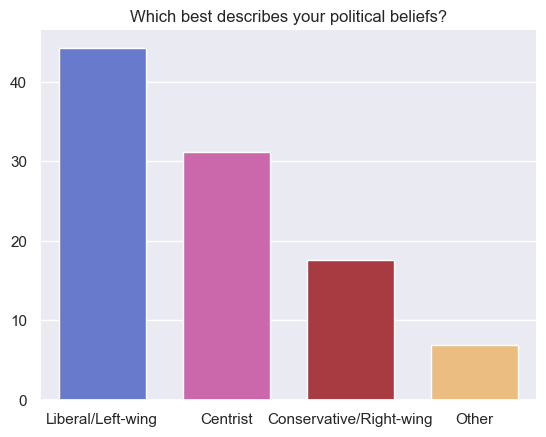

In [7]:
# Get relative frequencies
freqs = data['political_belief'].value_counts(normalize=True)*100
title = questions.loc['q212813', 'text']
ax = sns.barplot(x=['Liberal/Left-wing', 'Centrist', 'Conservative/Right-wing', 'Other'], y=freqs.values,
            order=['Liberal/Left-wing', 'Centrist', 'Conservative/Right-wing', 'Other'],
            palette={'Liberal/Left-wing': '#5770db', 'Centrist': '#db57b2', 'Conservative/Right-wing': '#ba2832', 'Other': '#fdbf6f'},
            width=0.7
            ).set(title=title)
sns.despine(top=True, right=True)
plt.savefig("data/images/Political_Belief_Distribution.png")
plt.show()

In [8]:
def plot_question_distribution(question: str, data: pd.DataFrame, questions: pd.DataFrame):
    x,y = question, 'political_belief'
    df1 = data.groupby(x)[y].value_counts(normalize=True).rename('density').reset_index()
    title = questions.loc[question, 'text']

    g = sns.catplot(x='density',y=x,hue=y, kind='bar', data=df1, 
                hue_order= ['Liberal / Left-wing', 'Centrist', 'Conservative / Right-wing', 'Other'], 
                palette={'Liberal / Left-wing': '#5770db', 'Centrist': '#db57b2', 'Conservative / Right-wing': '#ba2832', 'Other': '#fdbf6f'},
                order = questions.loc[question, 'Order'],
                legend=False
                ).set(xlabel ="density", ylabel = "", title=title)
    plt.legend(title="", bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

In [28]:
for ind in questions.loc[descriptive_questions].index:
    print(ind)
    print(questions.loc[ind, 'Order'])
    ast.literal_eval(questions.loc[ind, 'Order'])

dq0
['Carefree', 'Intense']
dq1
['Yes', 'No']
dq2
['Warm-hearted', 'Cool-headed']
dq3
['Conversationalist', 'Listener']
dq4
['Private', 'Social']
dq5
['Yes', 'No']
dq6
['Yes', 'No']
dq7
['Fast', 'Careful']
dq8
['Very often', 'Sometimes', 'Rarely', 'Never']
dq9
['I smoke regularly.', 'I smoke occasionally.', 'I smoked in the past, but no longer.', 'Never.']
dq10
['I do drugs regularly.', 'I do drugs occasionally.', "I've done drugs in the past, but no longer.", 'I never do drugs.']
dq11
['Lots', 'Sometimes', 'Rarely', 'Never']
dq12
['Yes', 'No']
dq13
['Yes', 'No']
dq14
['Yes', 'No']
dq15
["I'm very messy", "I'm average", "I'm mostly organized", "I'm compulsively neat"]
dq16
['Yes', 'No']
dq17
['Watch television', 'Read']
dq18
['mostly guys', 'mostly girls', 'both guys and girls']
dq19
['Yes', 'No']
dq20
['Yes', 'No']
dq21
['Yes', 'No']
dq22
['Yes', 'No']
dq23
['Yes', 'No']
dq24
['Yes', 'No']
dq25
['Yes', 'No']
dq26
['Yes', 'No']
dq27
['Yes', 'No']
dq28
['Yes', 'No']
dq29
['Yes', 'No']
d

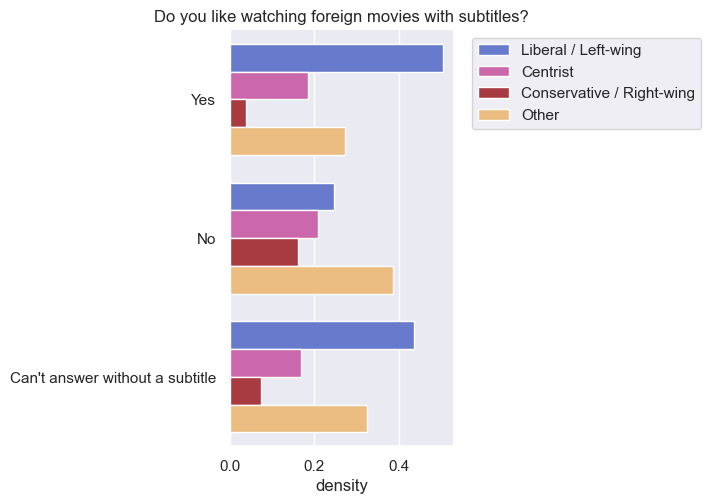

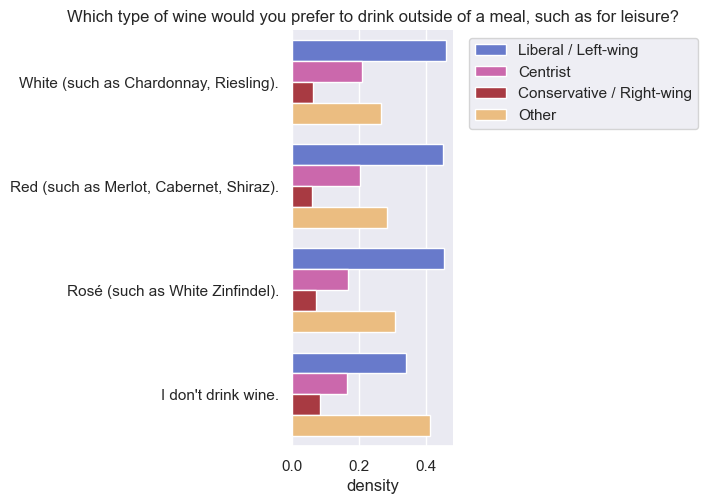

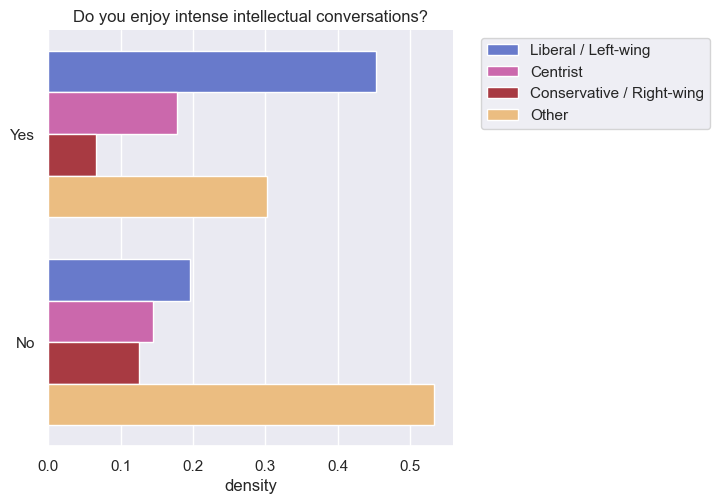

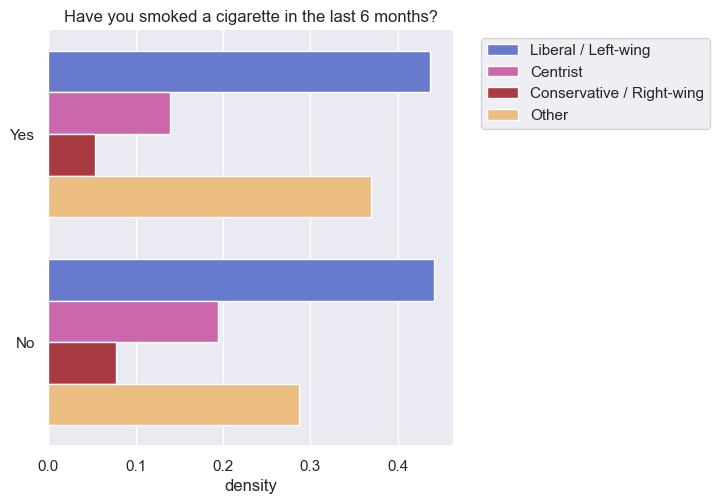

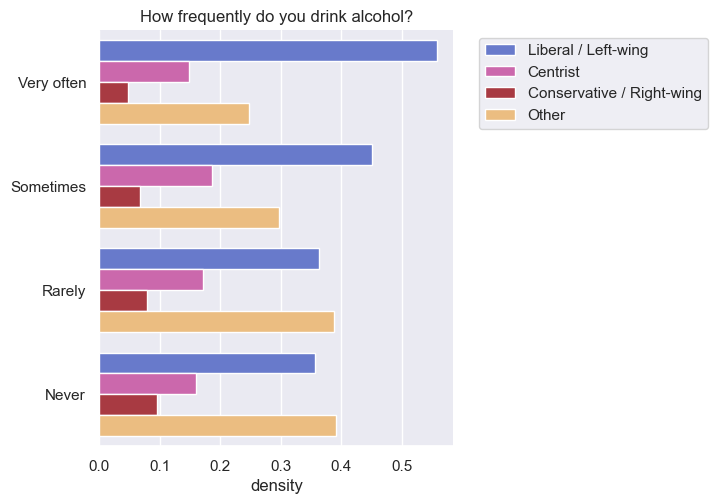

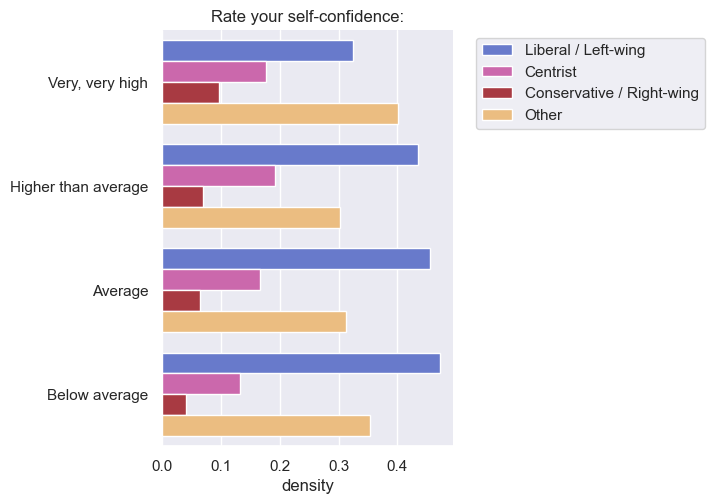

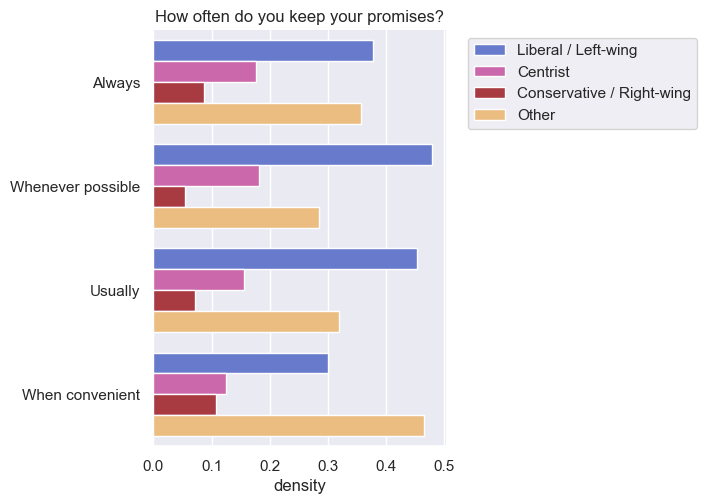

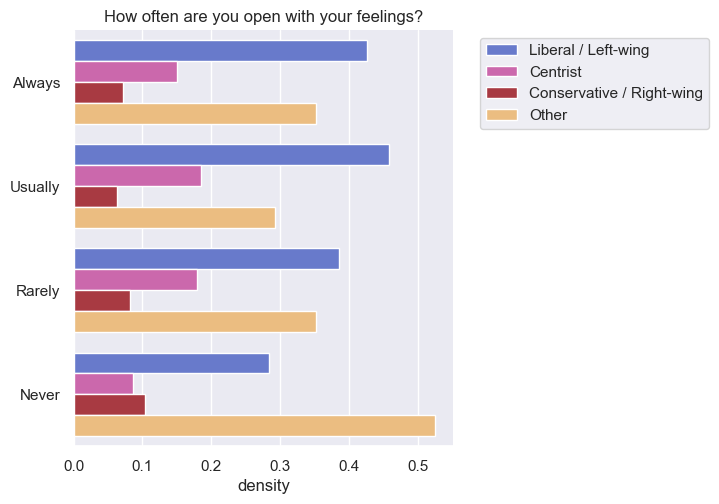

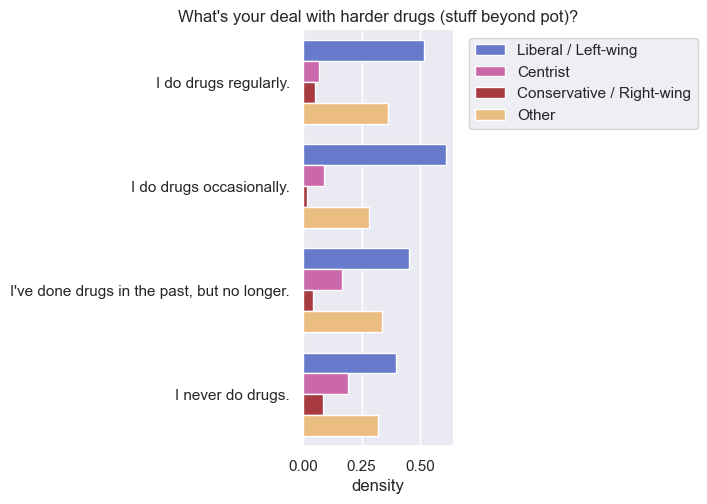

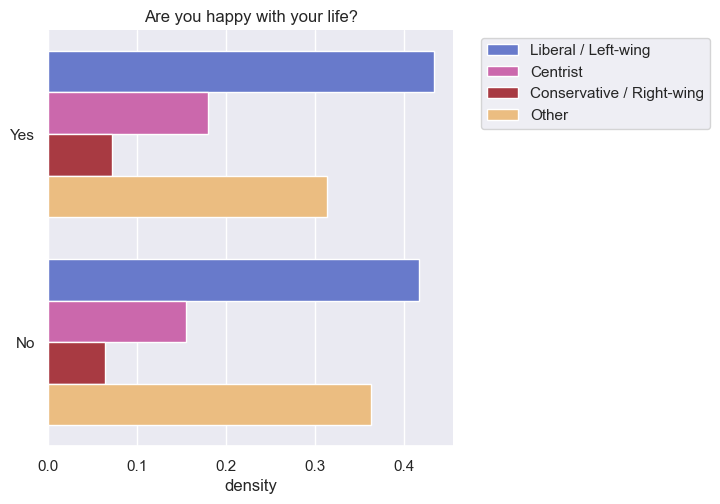

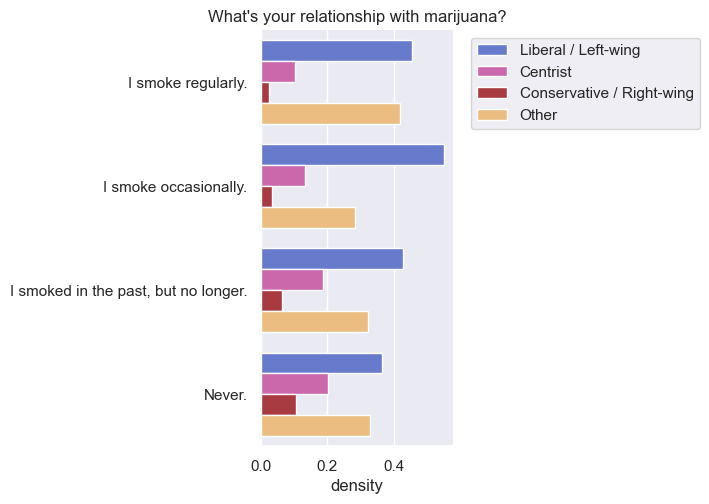

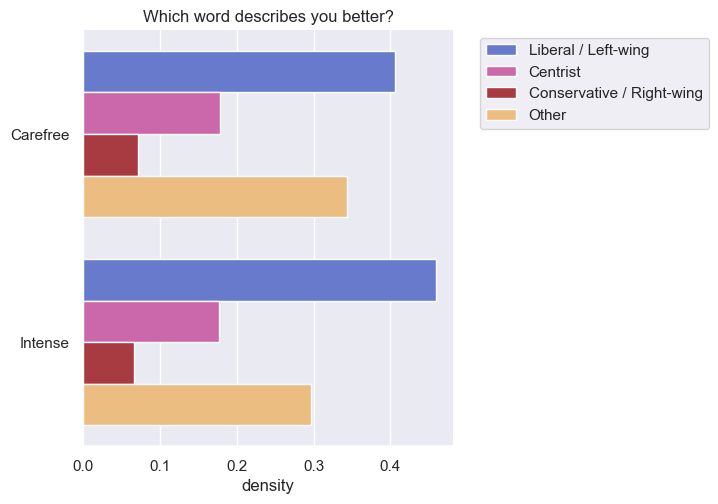

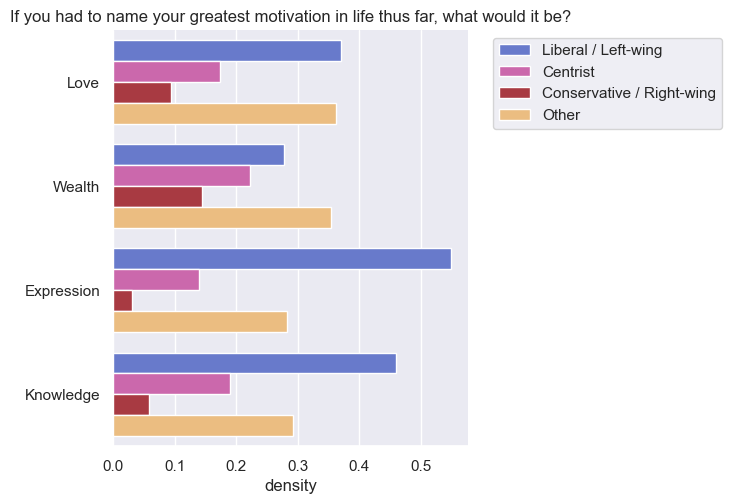

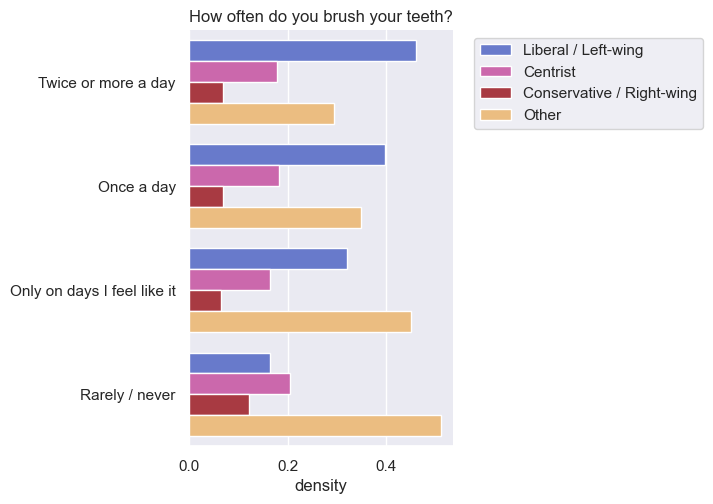

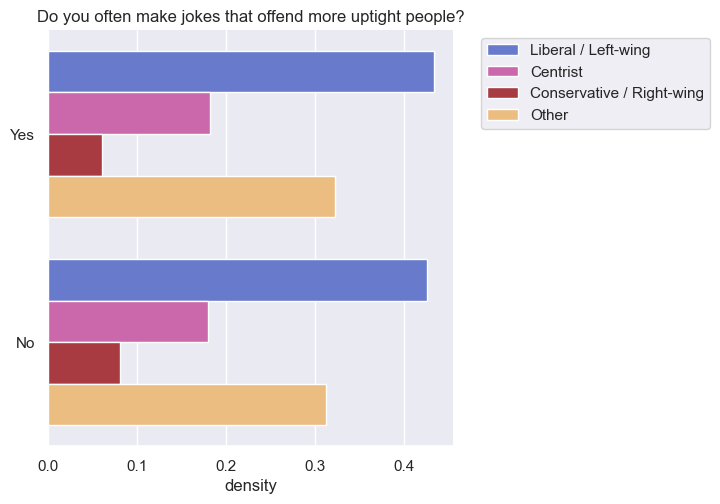

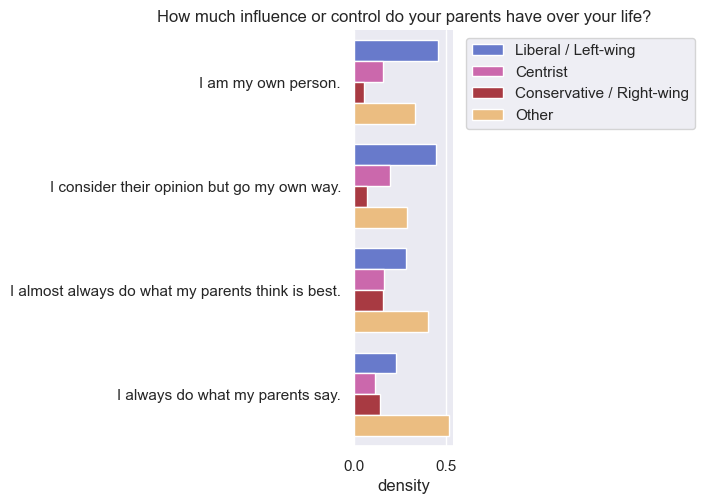

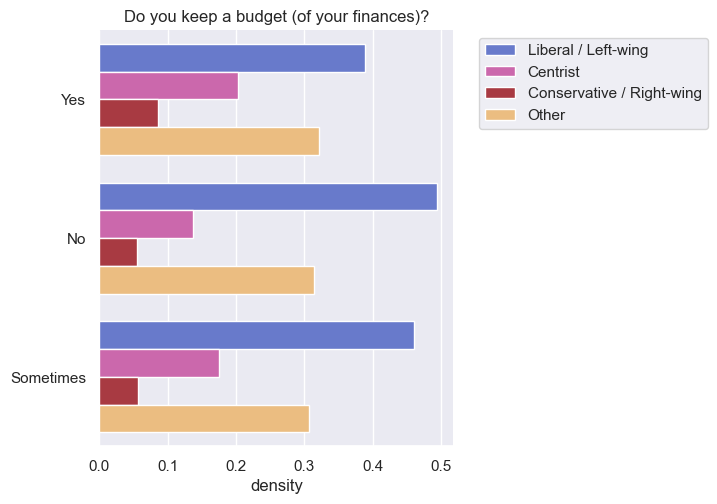

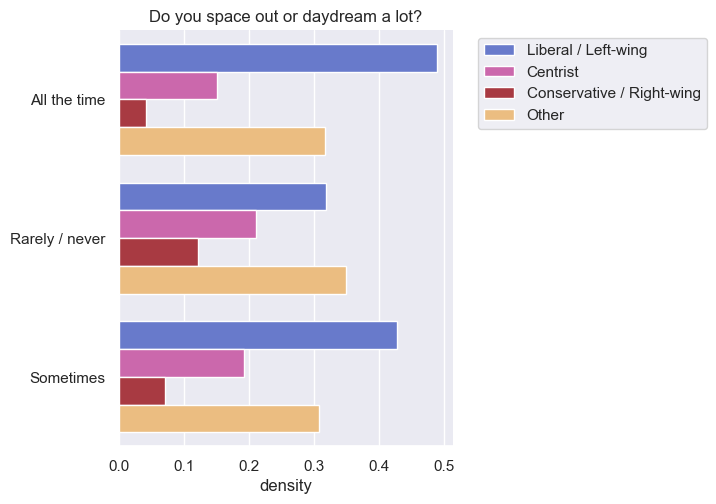

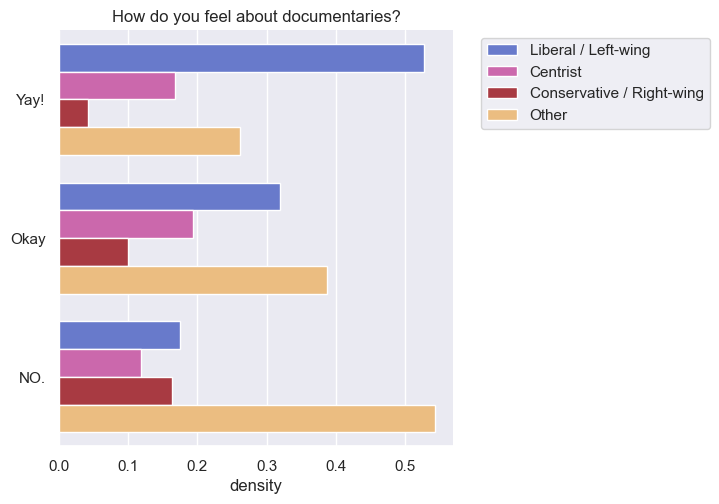

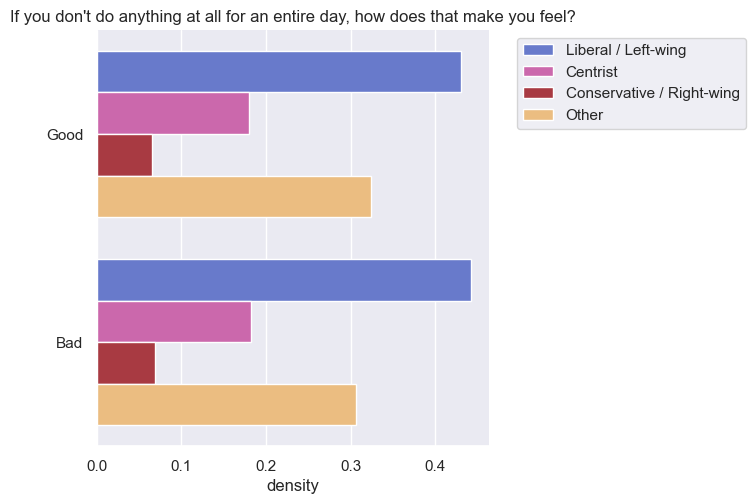

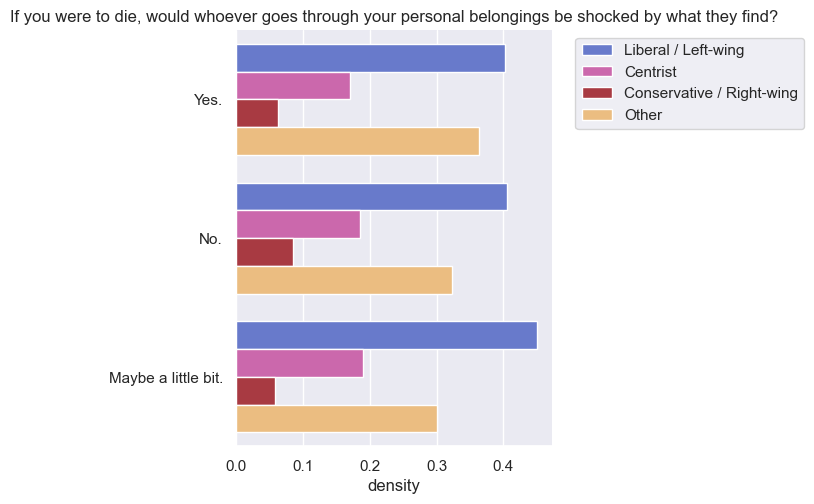

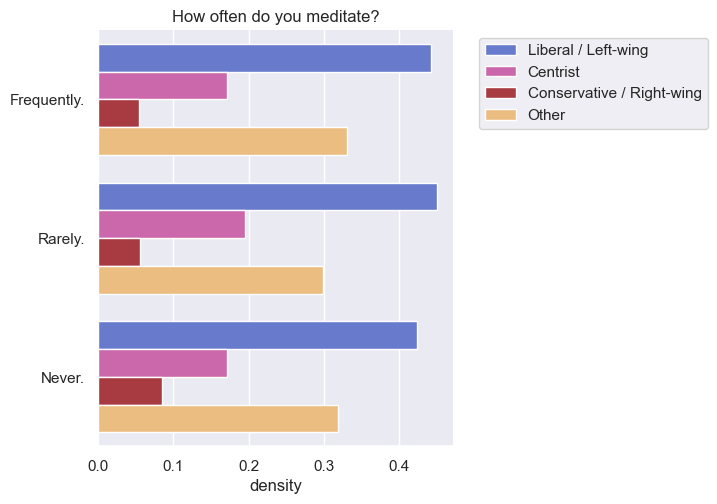

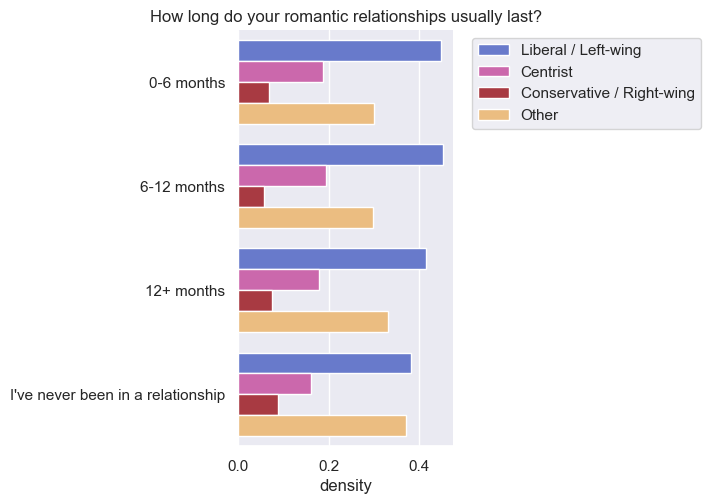

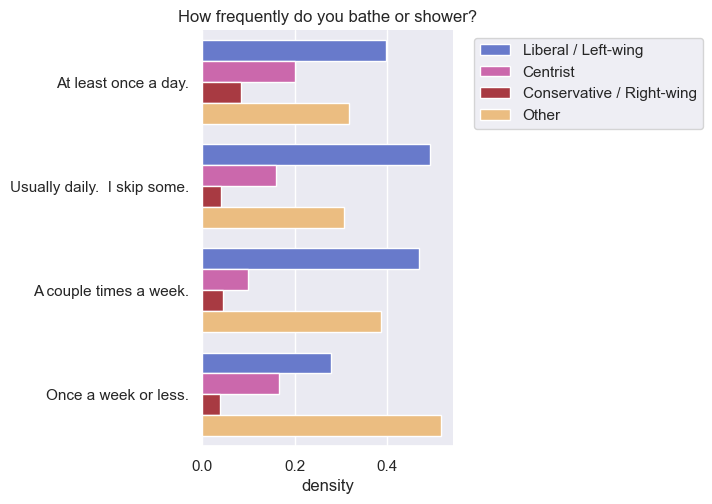

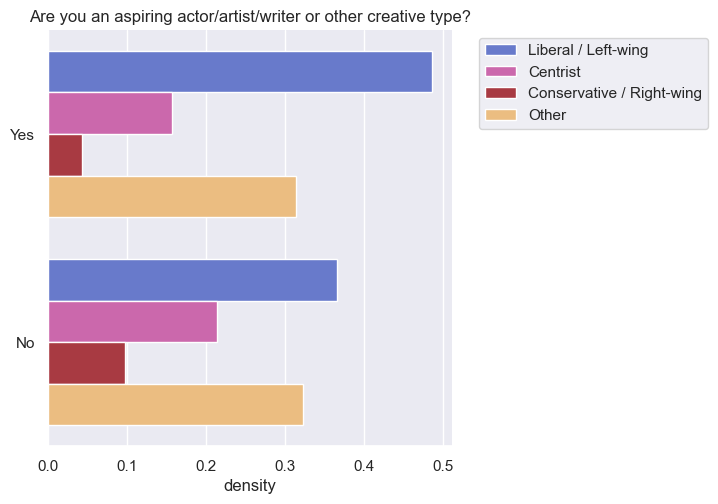

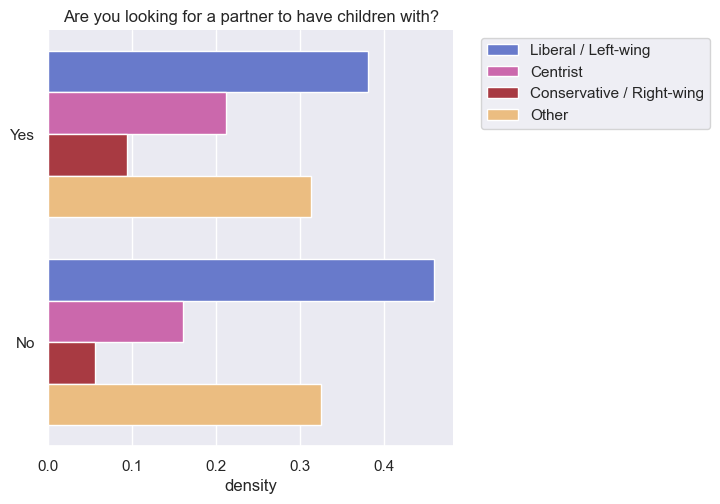

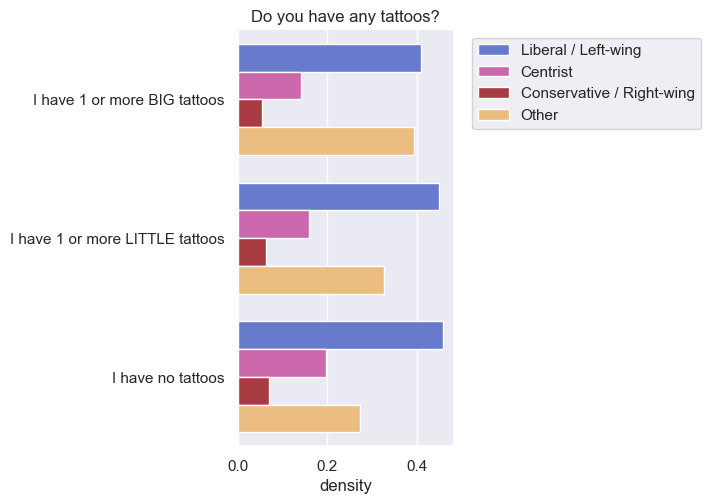

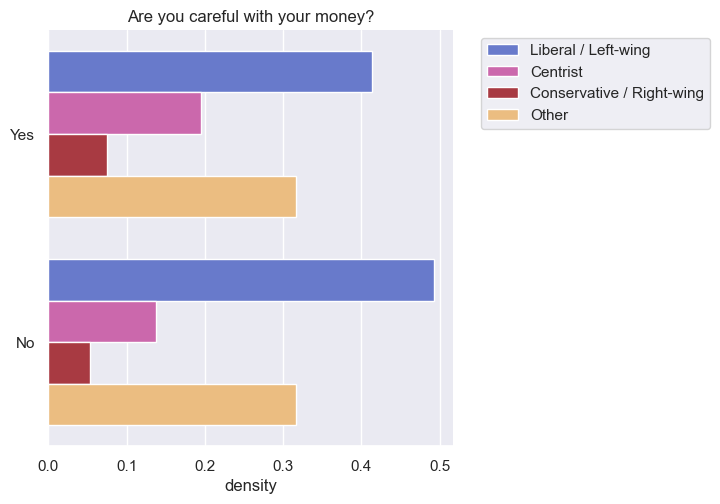

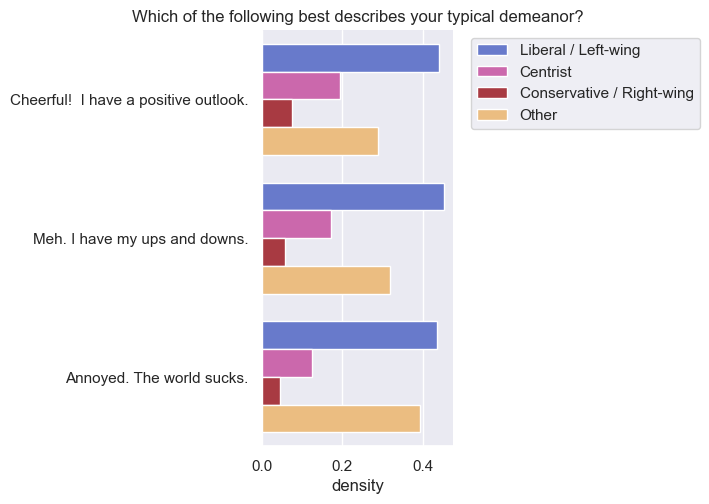

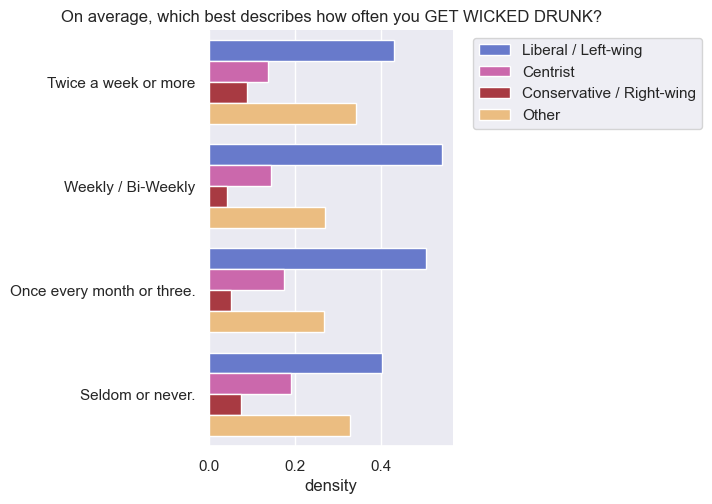

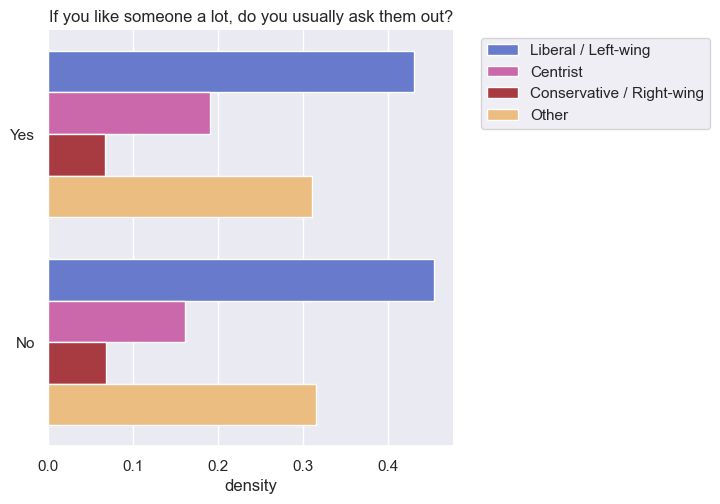

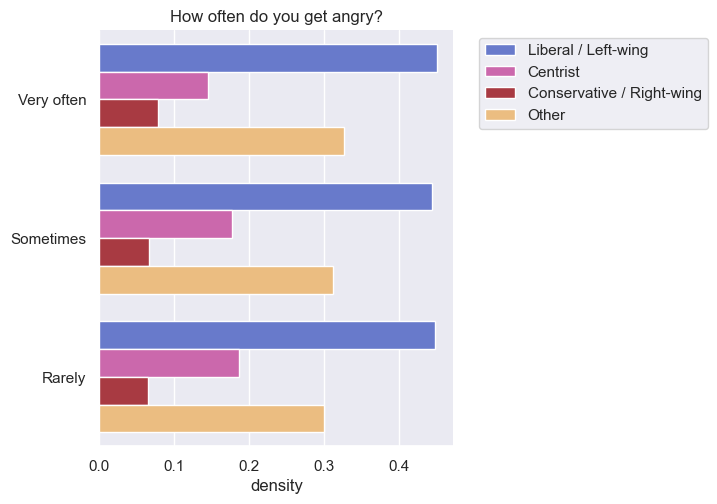

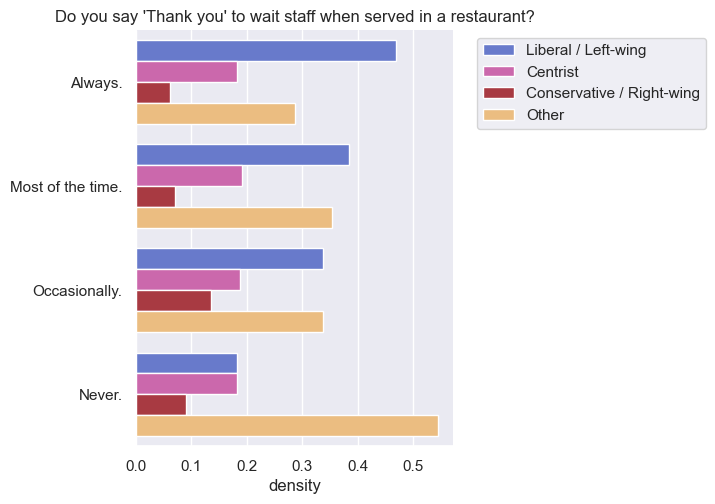

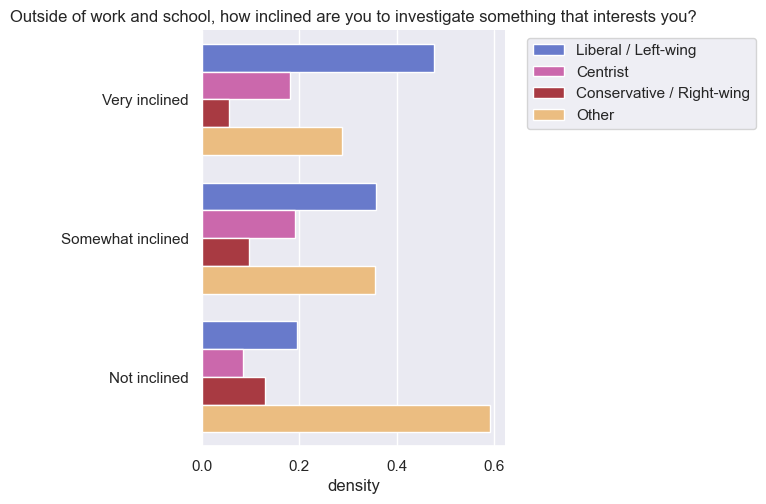

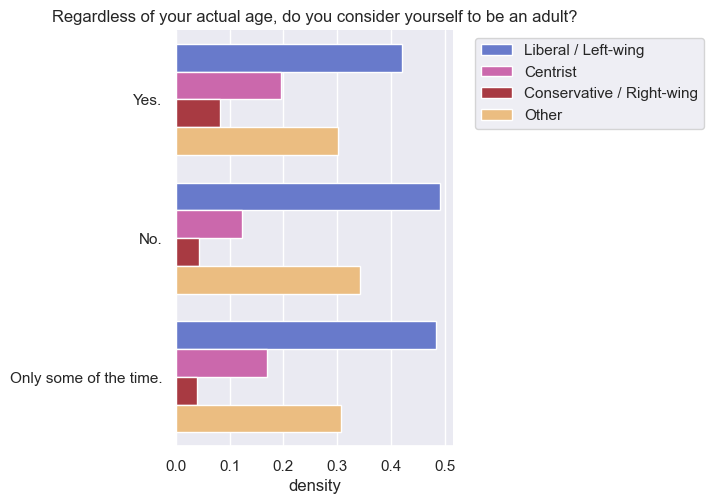

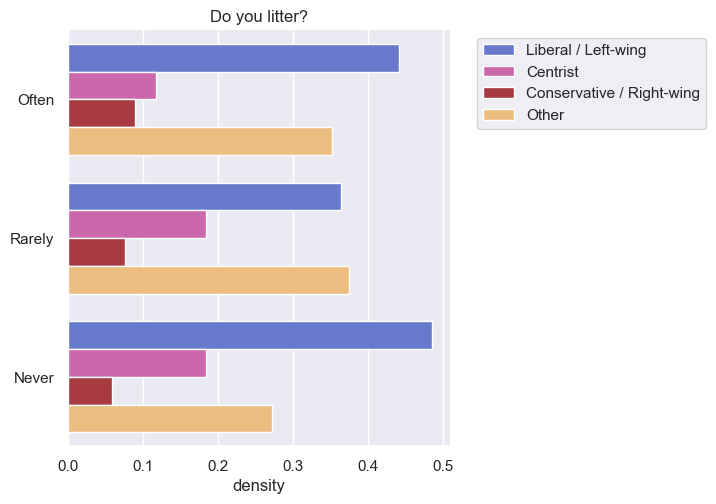

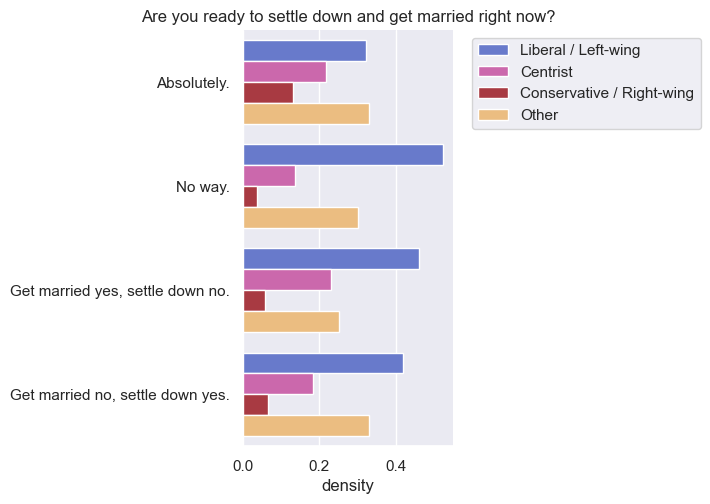

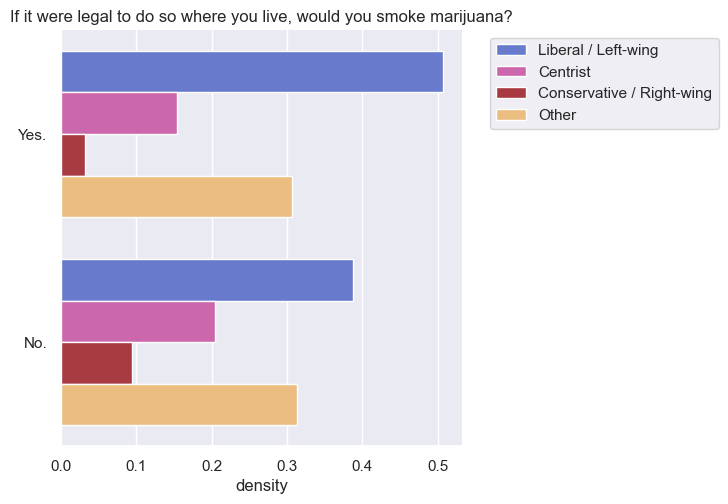

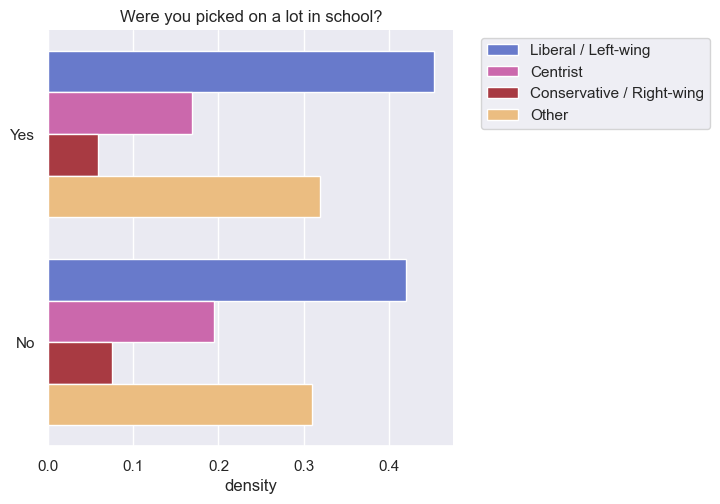

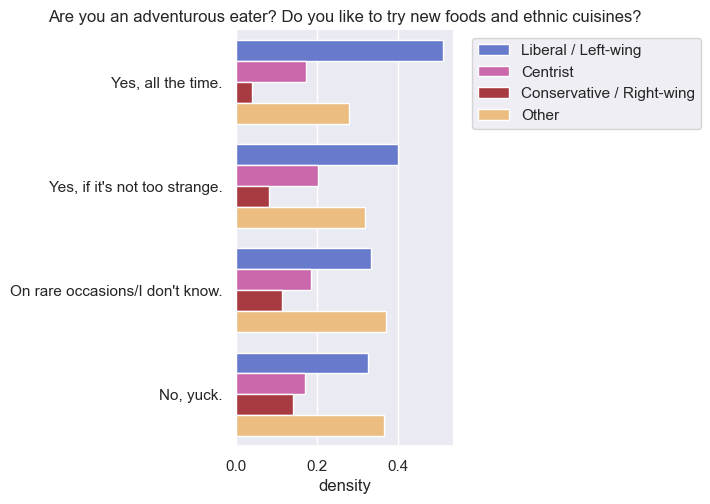

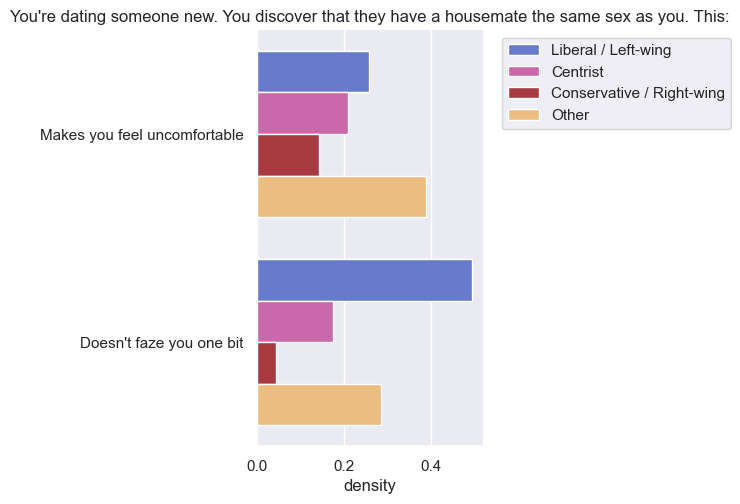

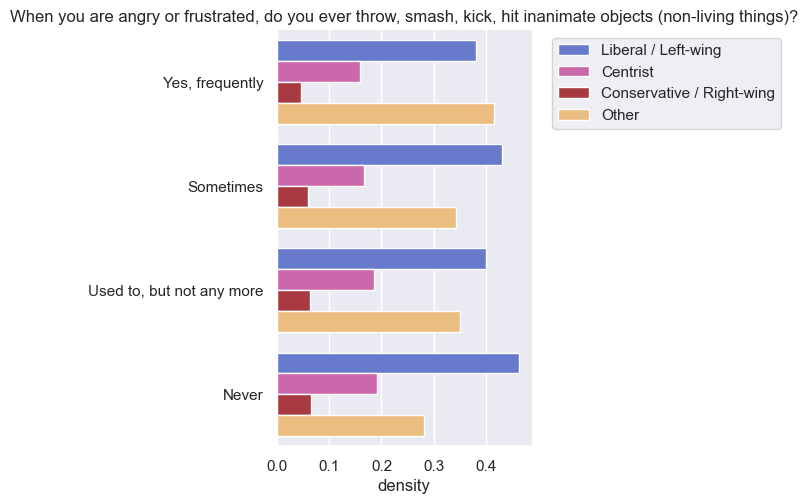

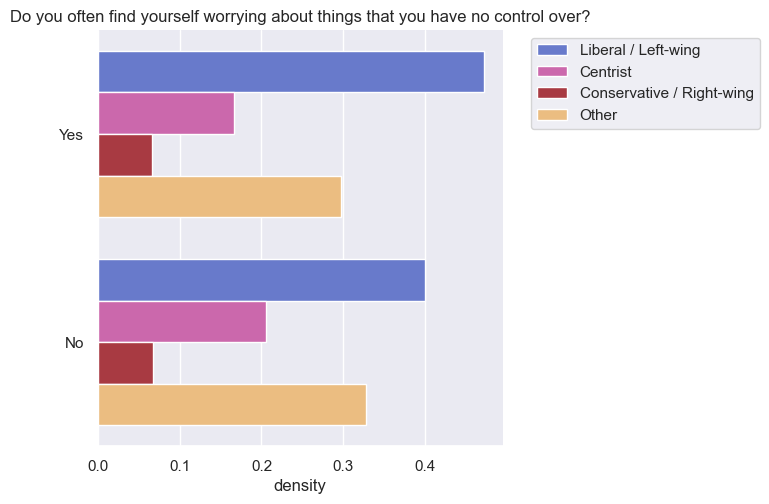

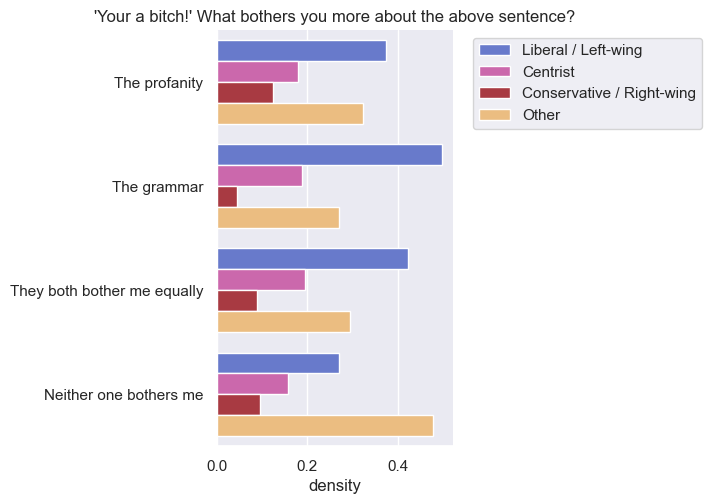

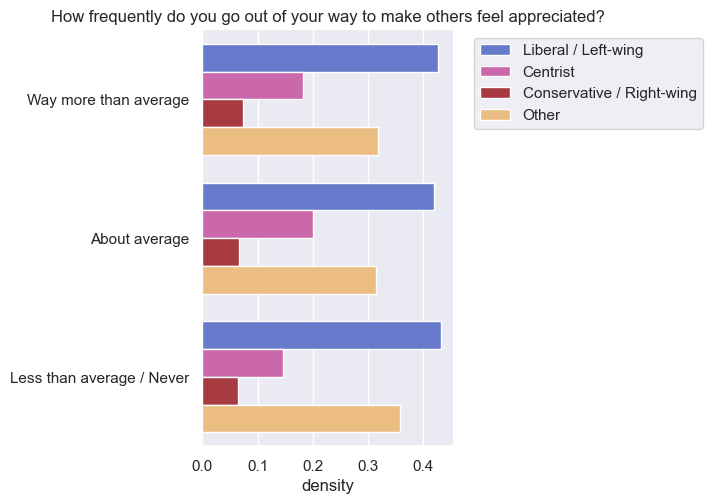

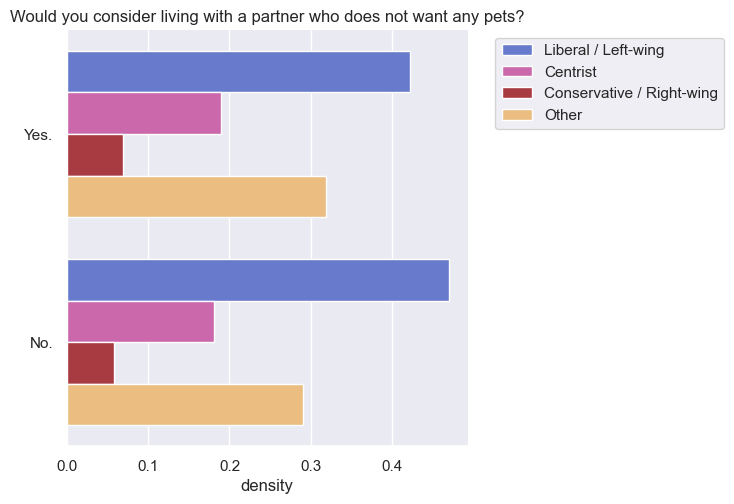

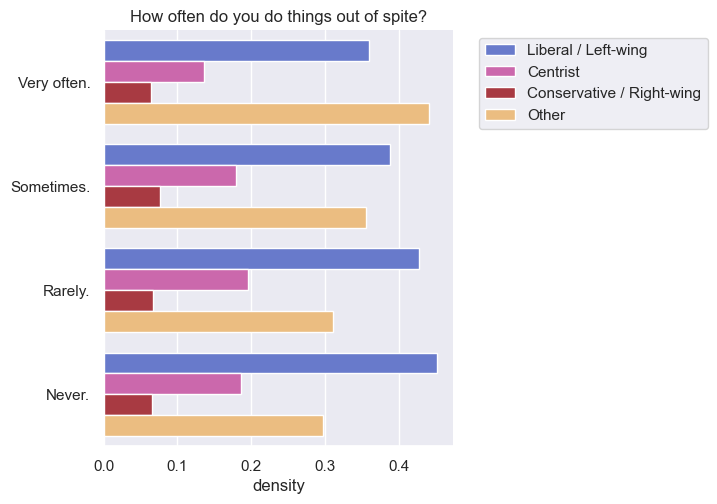

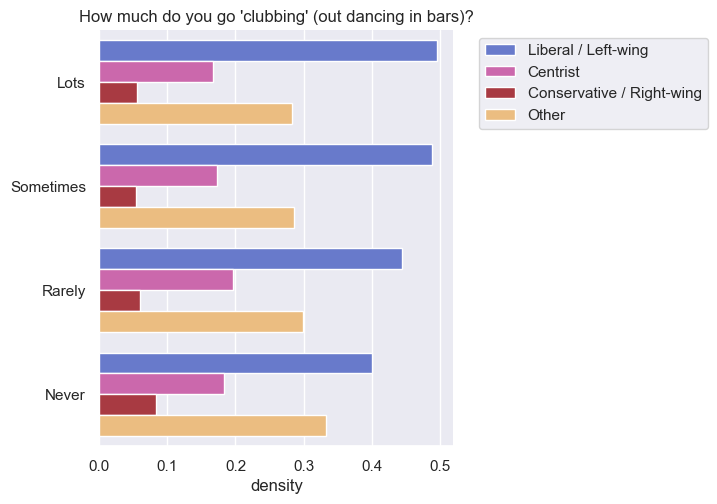

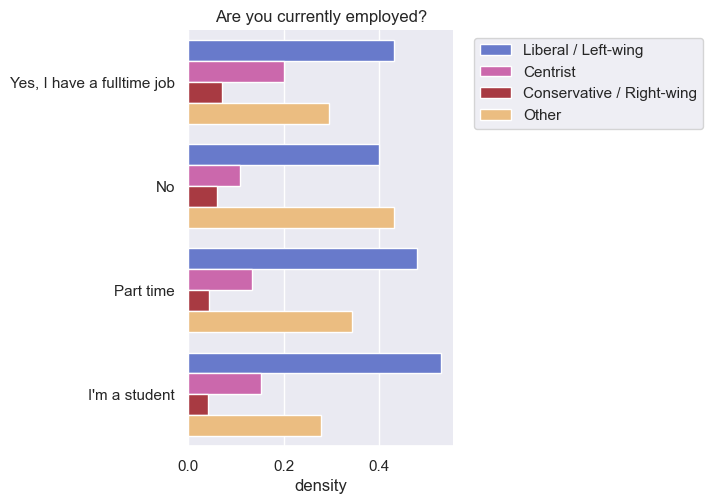

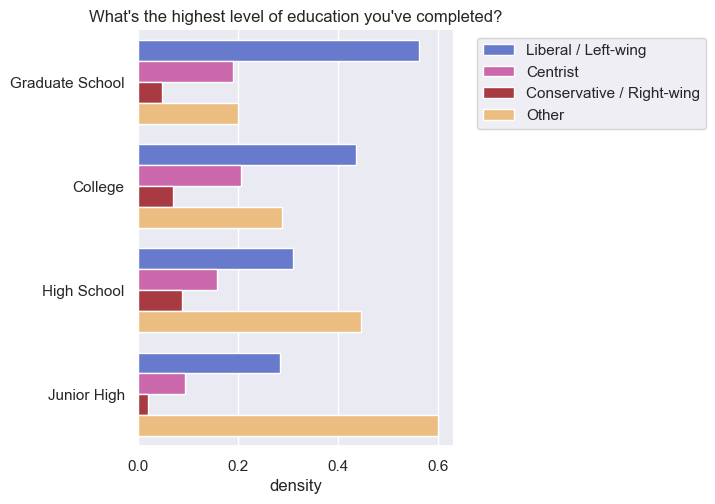

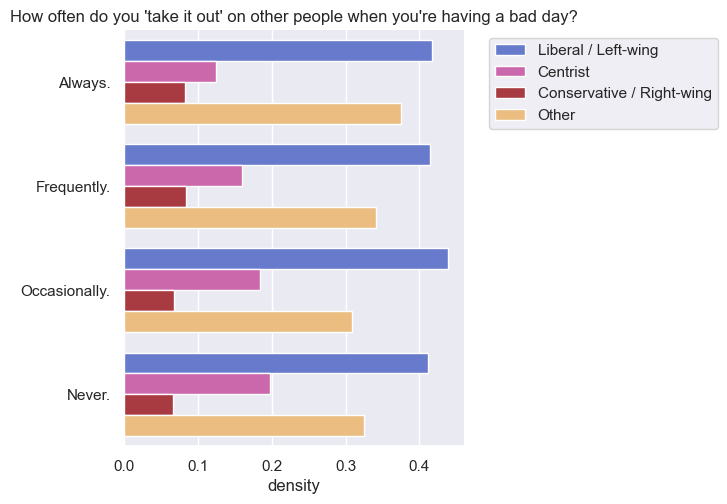

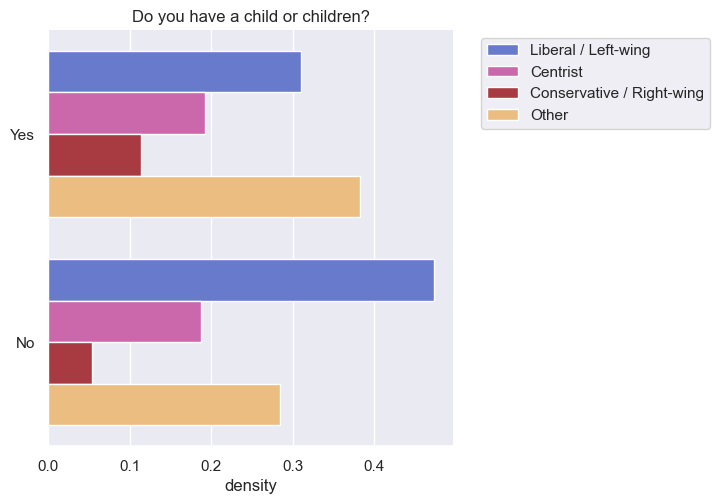

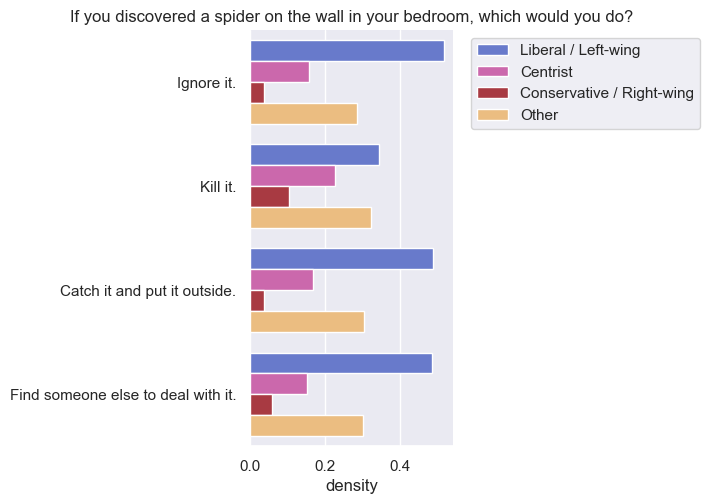

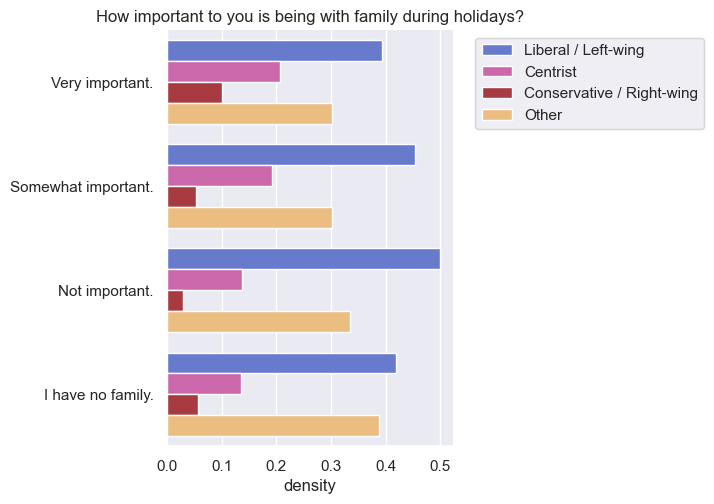

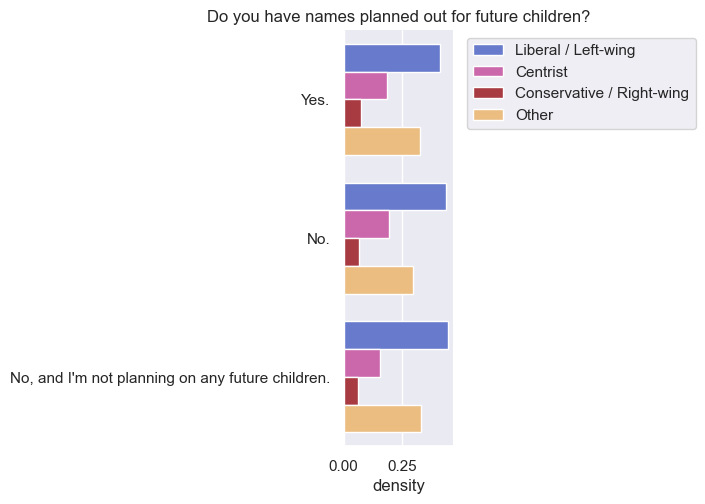

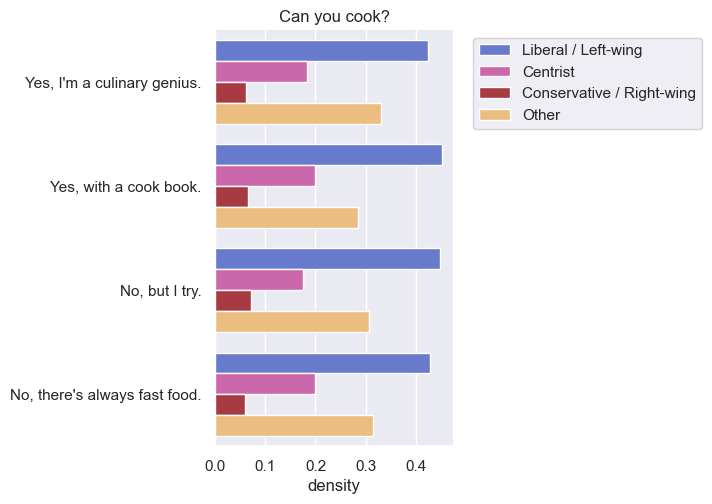

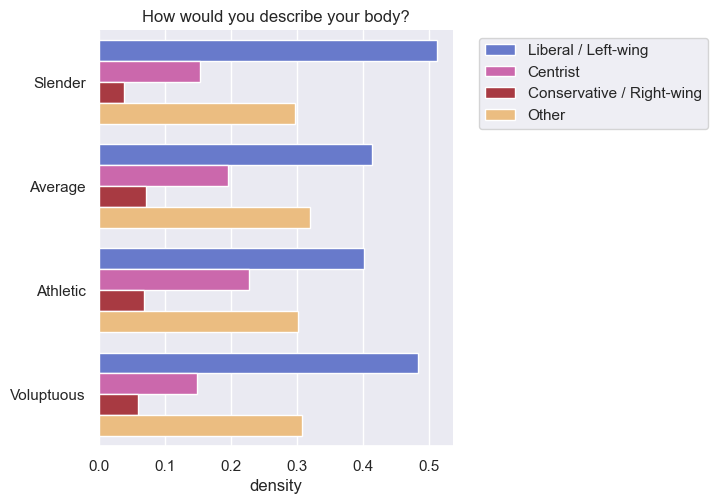

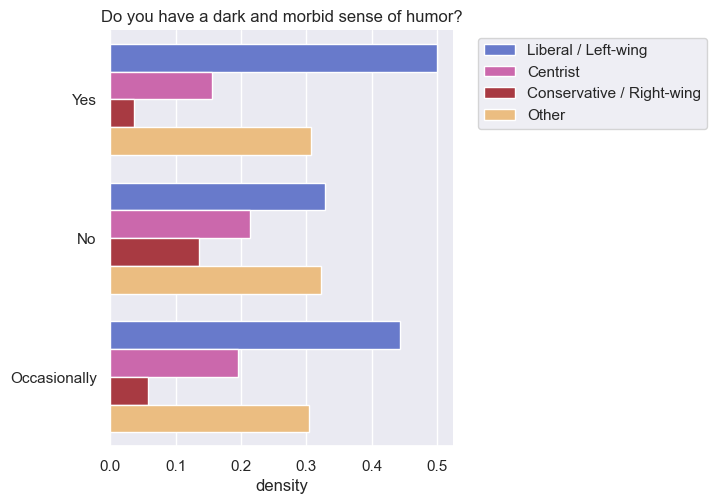

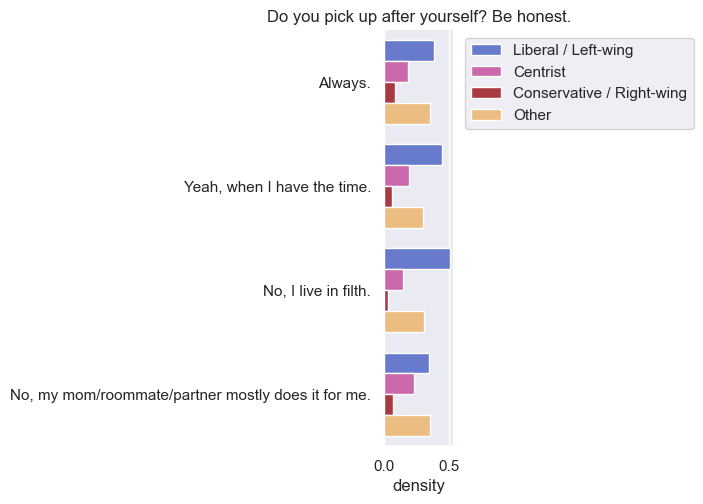

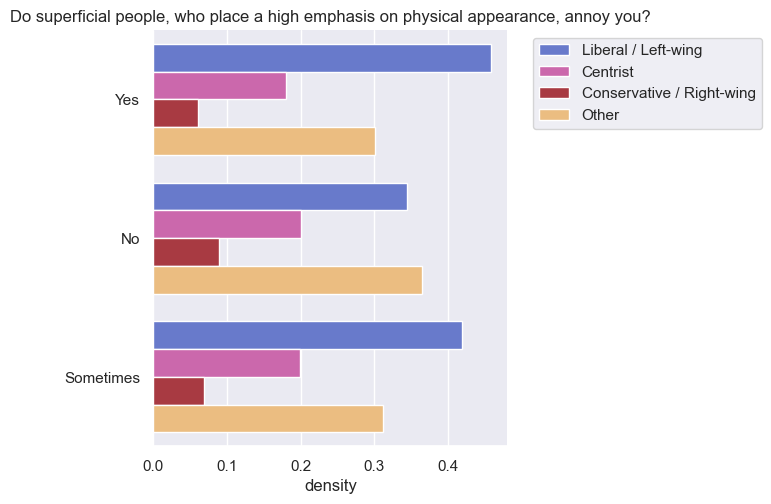

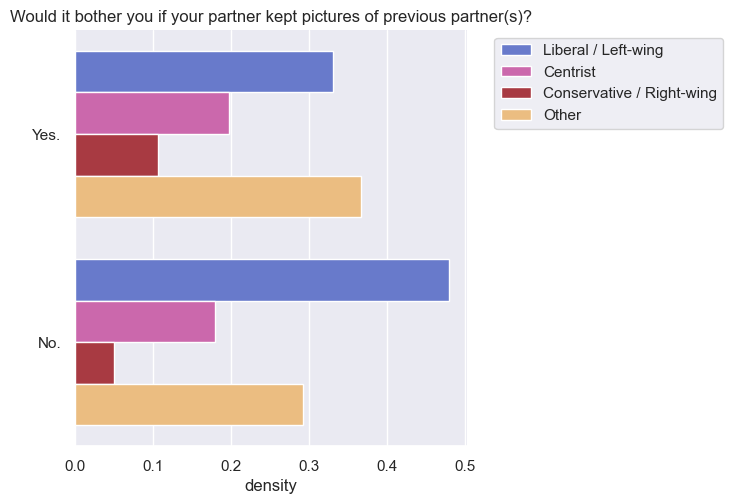

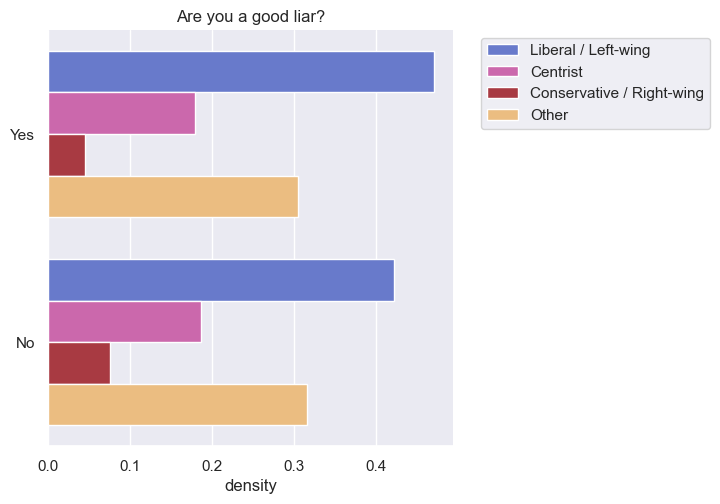

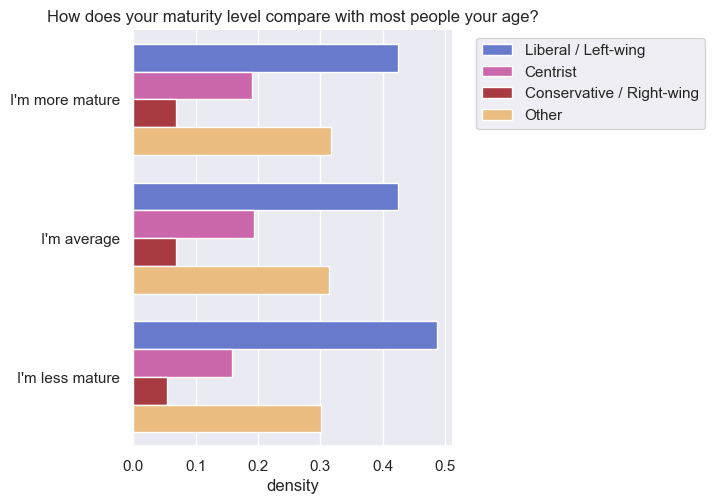

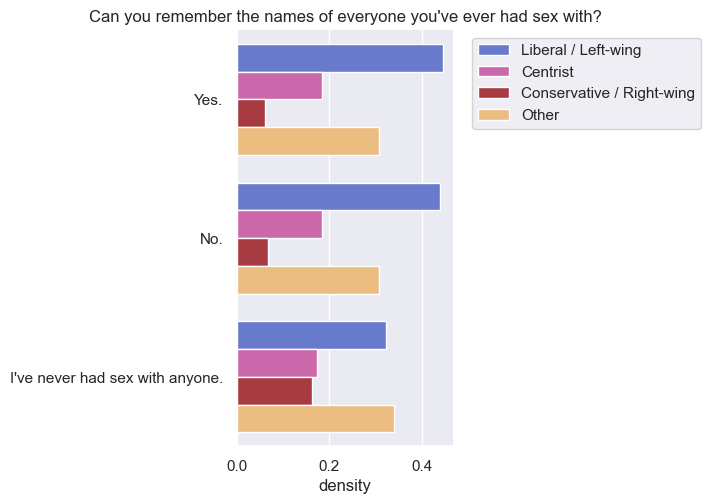

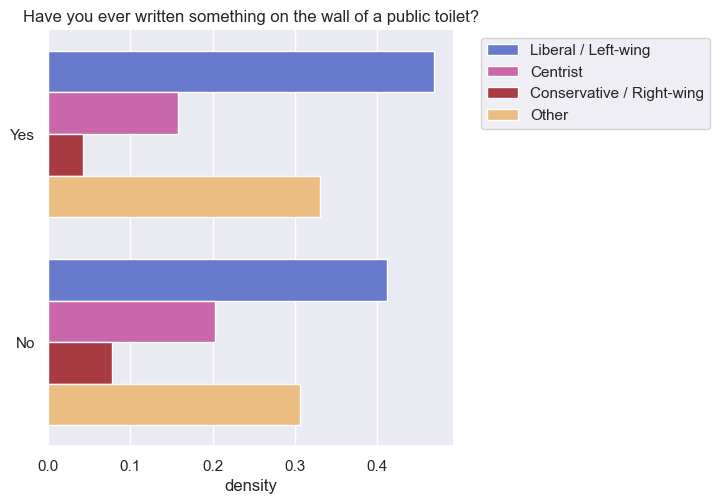

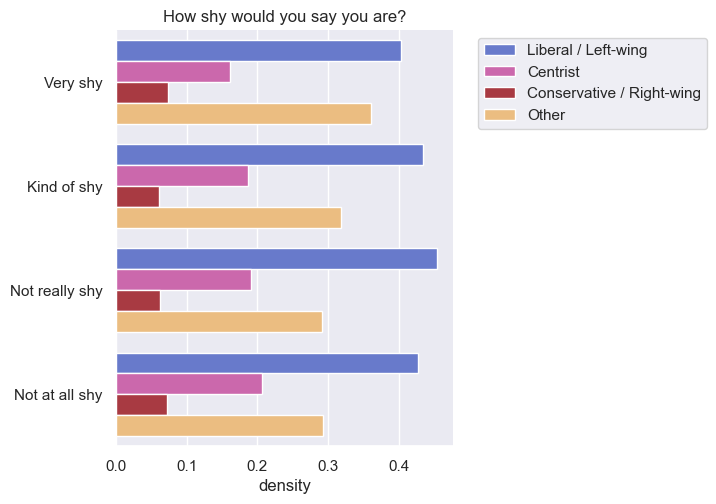

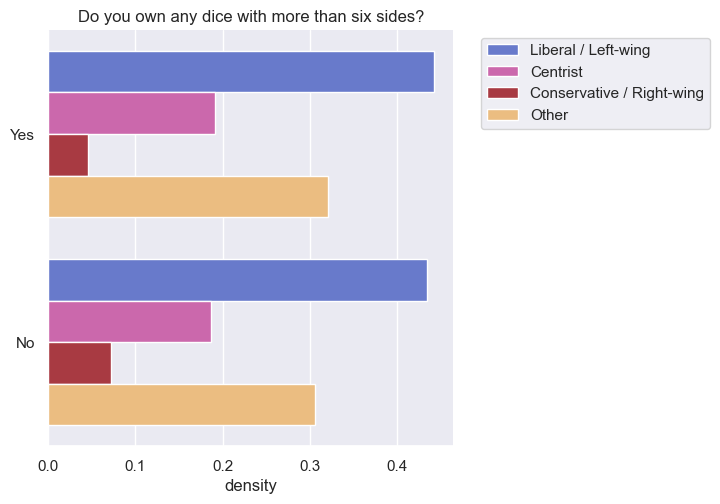

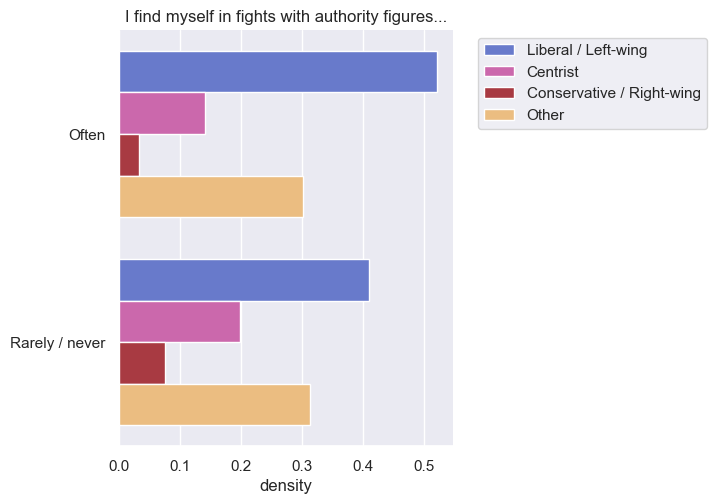

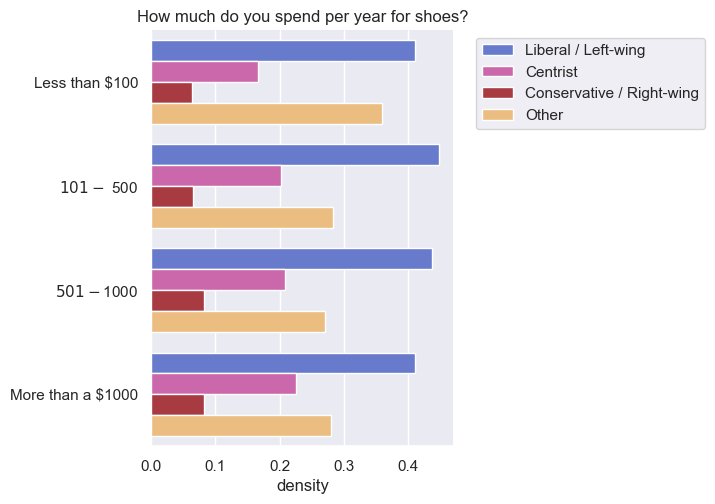

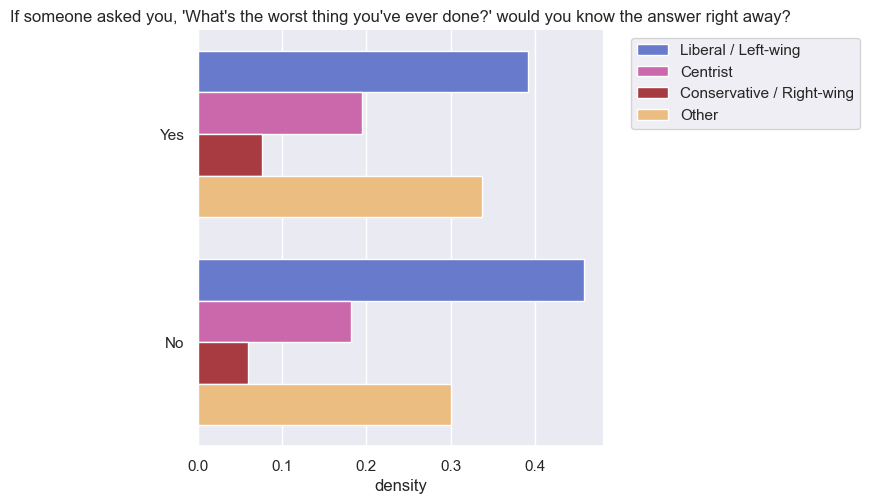

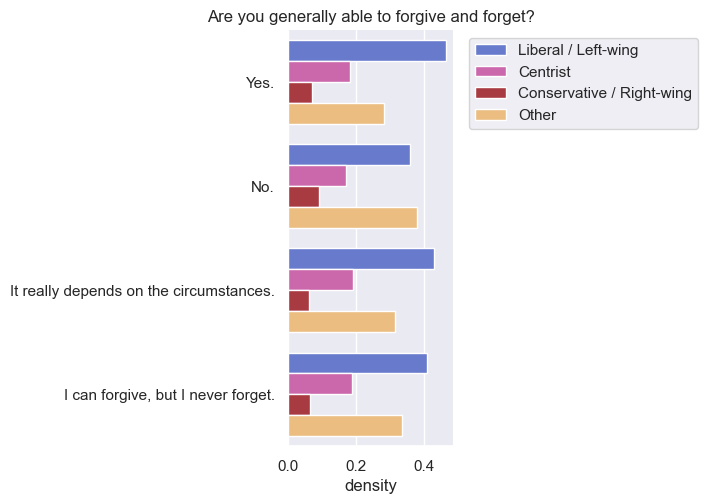

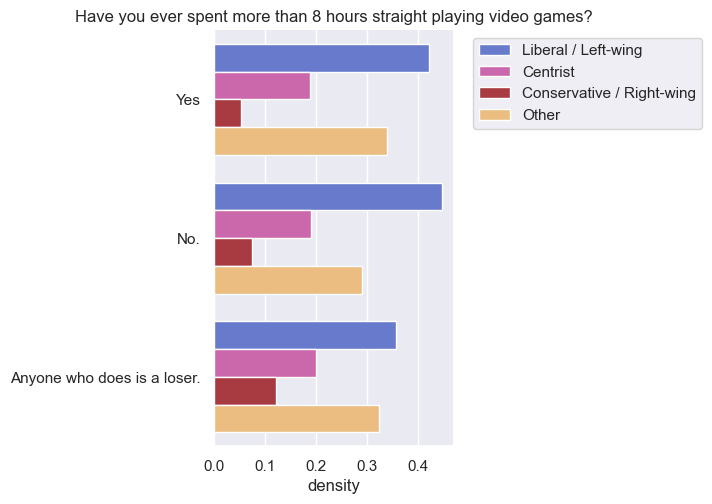

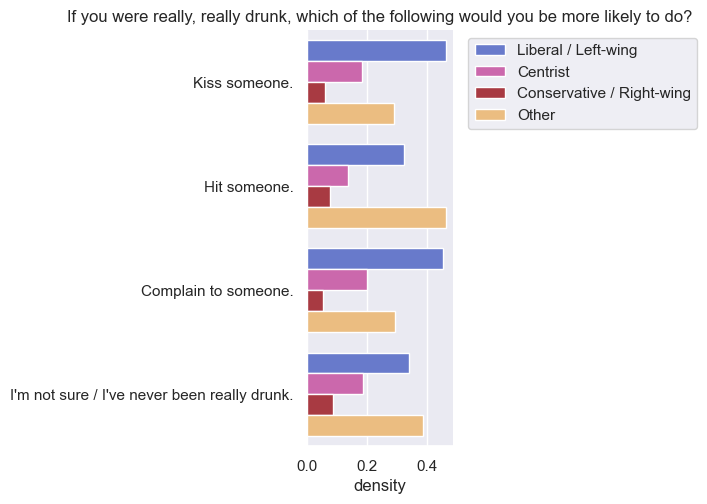

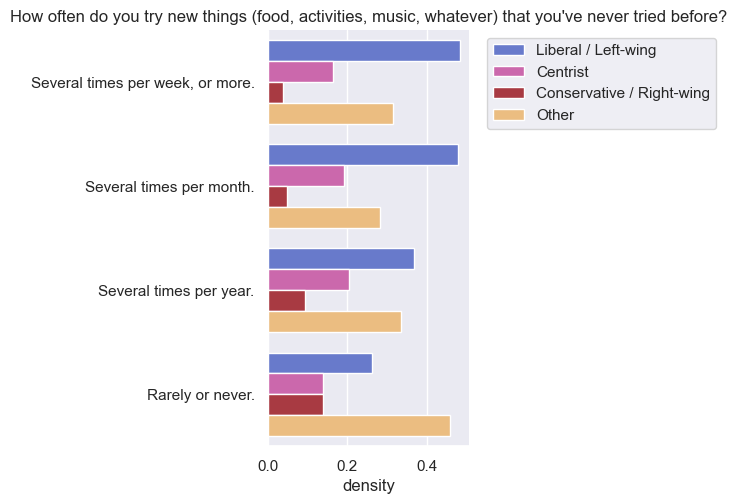

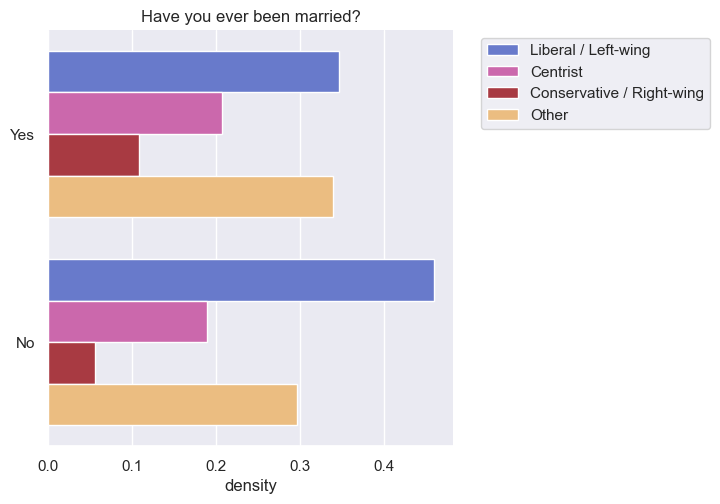

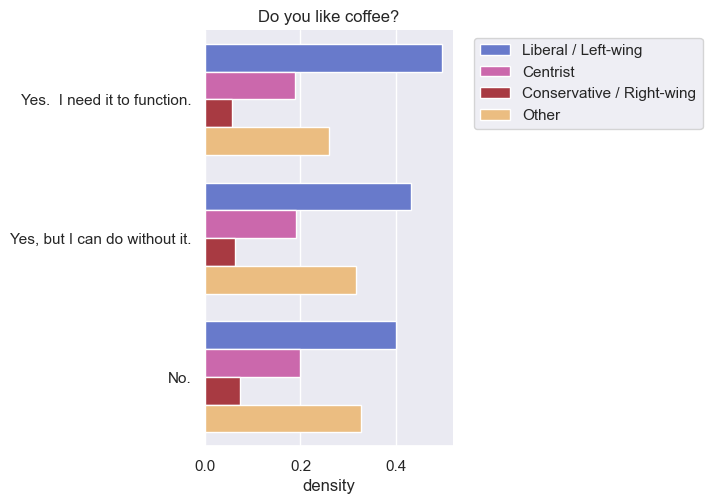

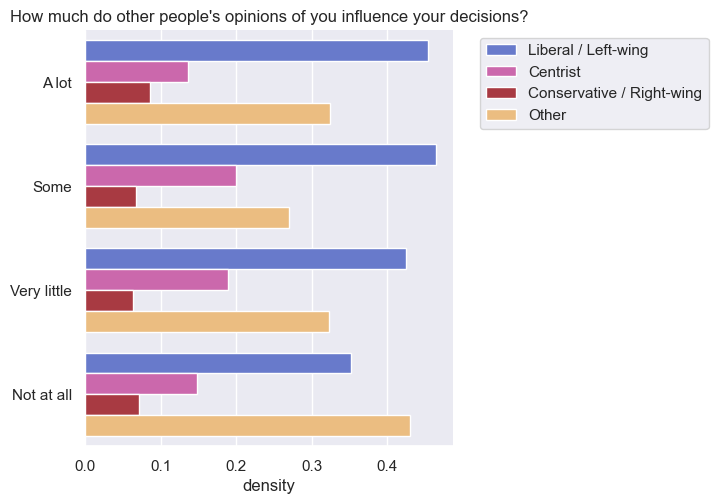

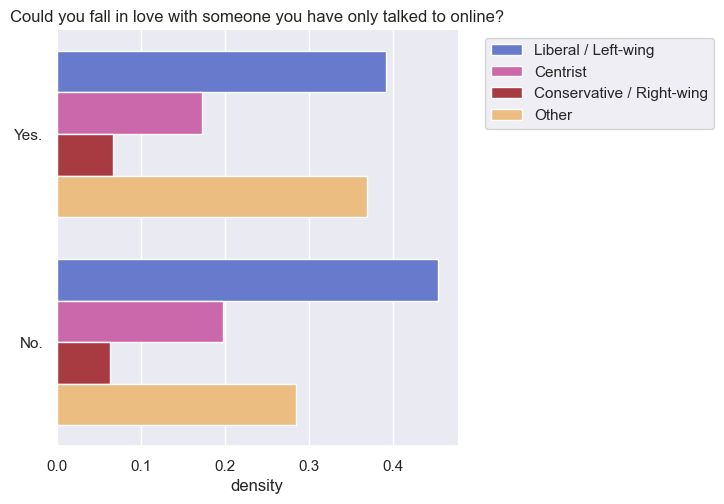

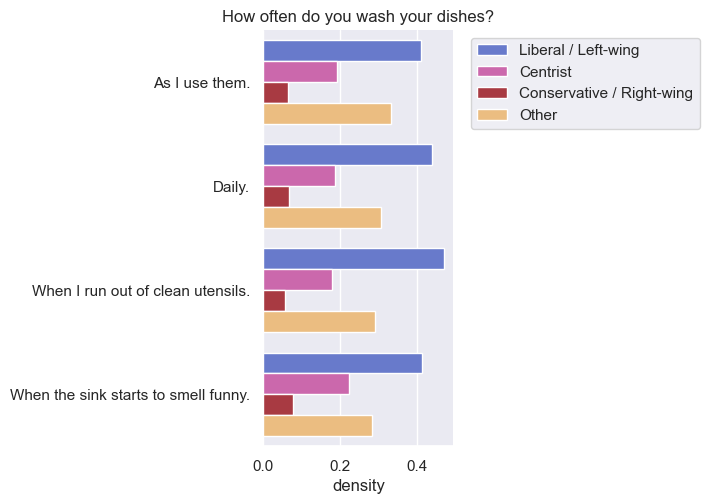

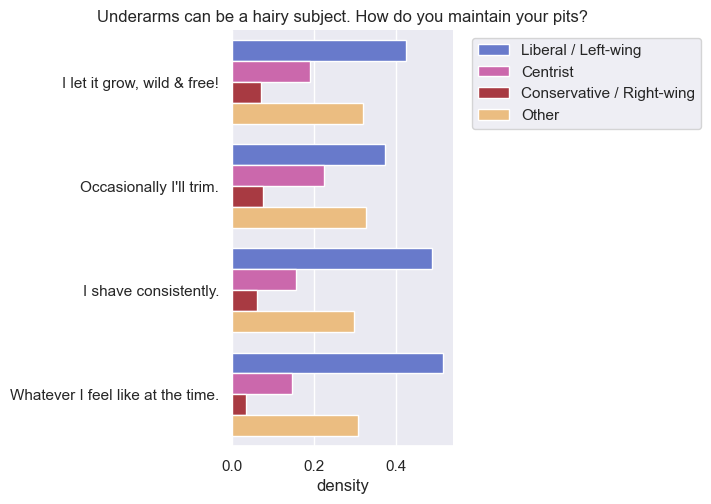

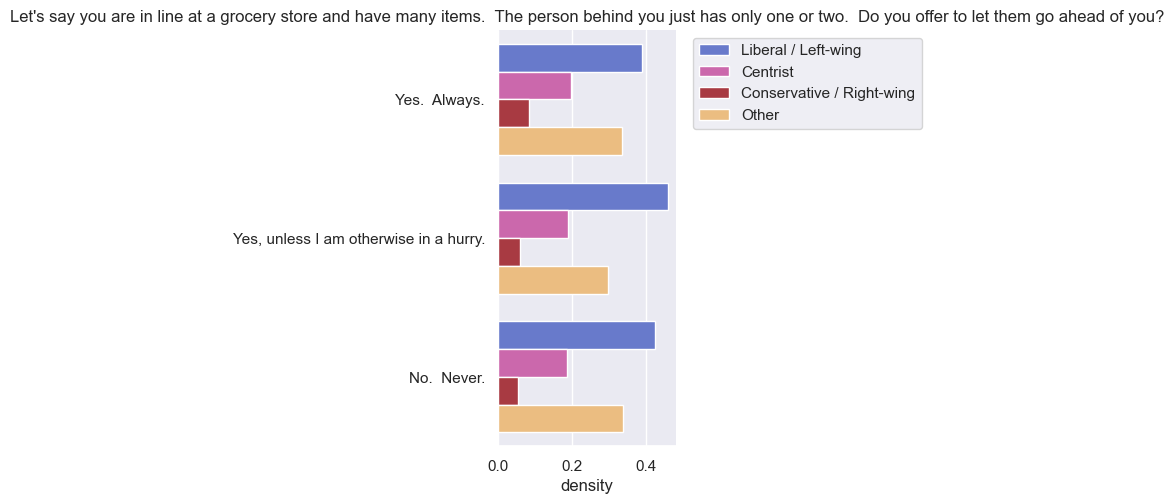

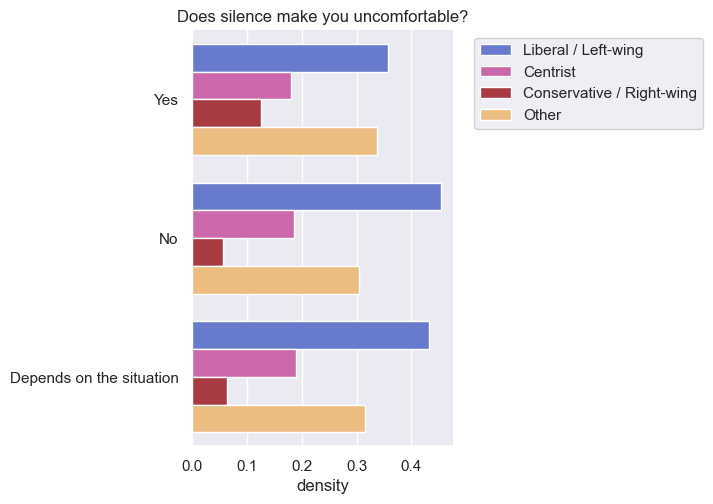

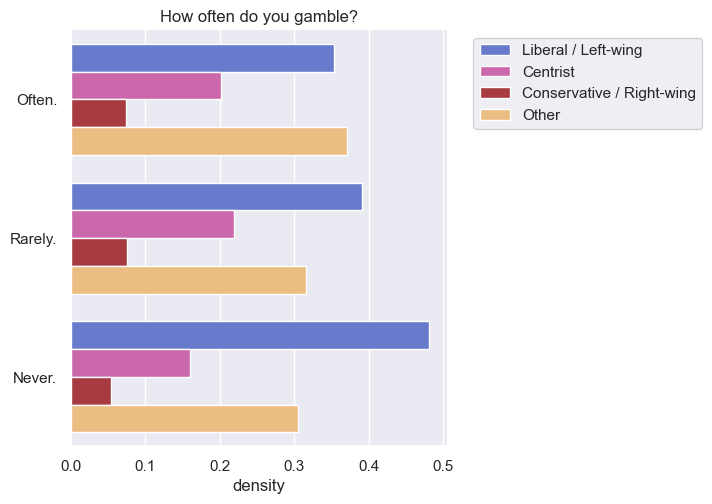

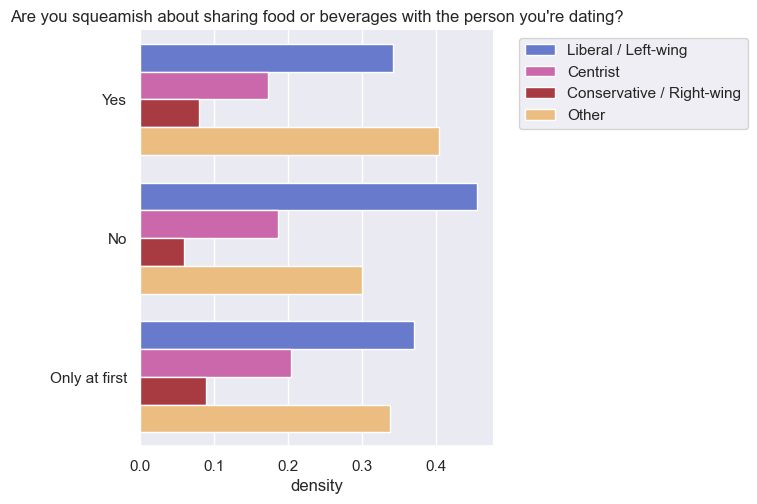

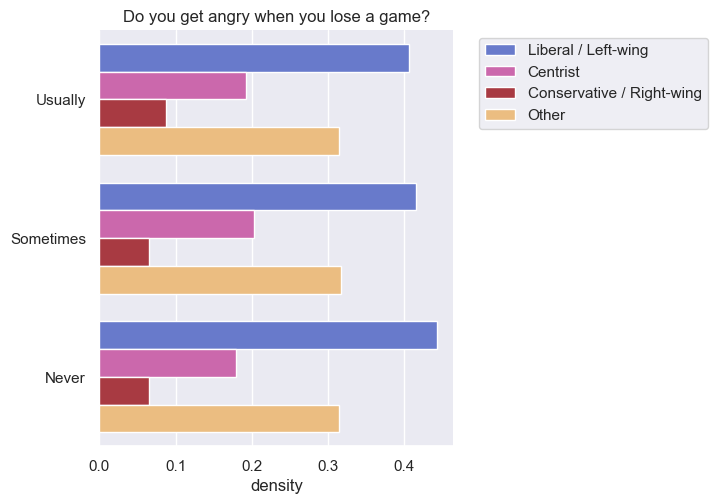

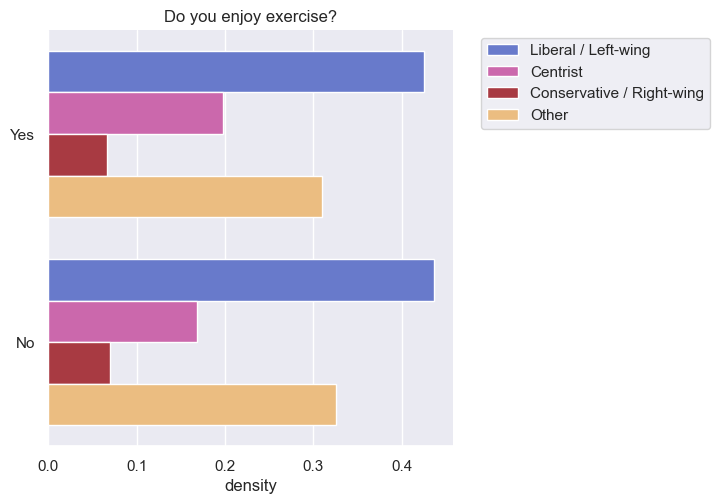

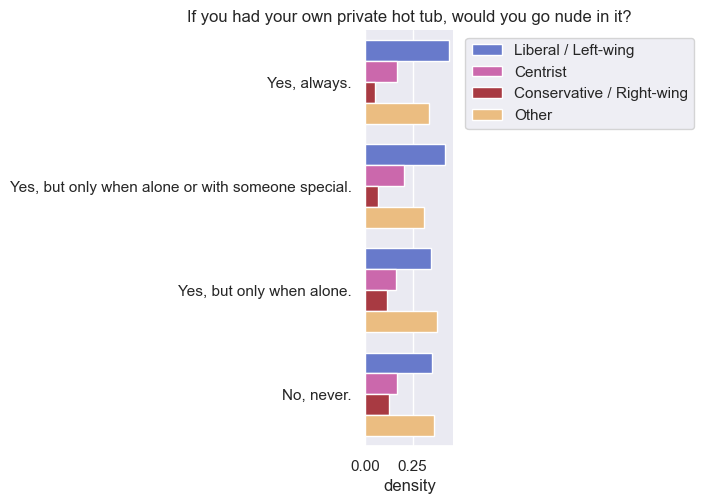

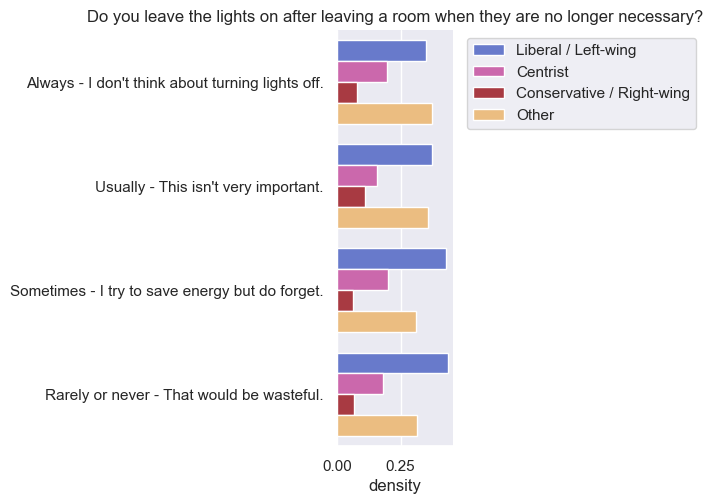

In [33]:
for question in sorted_questions[:100].to_list():
    plot_question_distribution(question, data, questions )

# Data preprocessing
To keep the train set reasonably big, we compute, how many questions we can include, s.t. that the nr. of subjects who answered these questions is at least 10.000. 


In [6]:
K=200
subset_size_topk = [features_df.loc[:, sorted_questions[:k]].dropna().shape[0] for k in range(1, K)]

In [7]:
# biggest k with >10.000 subjects who answered ALL k questions
min_train_size = np.arange(8, 25)*1000
n_most_answered = [next(x[0] for x in enumerate(subset_size_topk) if x[1] < min_set_size) for min_set_size in min_train_size]
n_most_answered

[62, 53, 48, 41, 36, 32, 27, 26, 23, 21, 18, 18, 17, 16, 15, 13, 12]

In [8]:
print(f'Shape of validation set before: {df_val.shape}')
top_questions = sorted_questions[:np.max(n_most_answered)].to_list()
df_val_topq = df_val[top_questions+['political_belief']].dropna() 
print(f'Shape of validation set after selecting the top {np.max(n_most_answered)} questions: {df_val_topq.shape}')

X_val_topq = df_val_topq[top_questions]
y_val = df_val_topq[['political_belief']]

Shape of validation set before: (3609, 829)
Shape of validation set after selecting the top 62 questions: (781, 63)


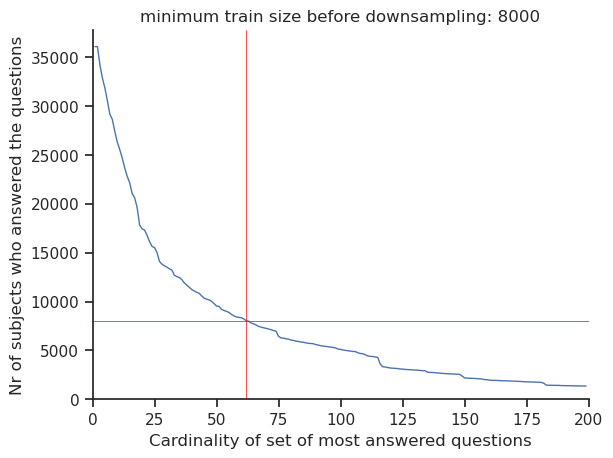

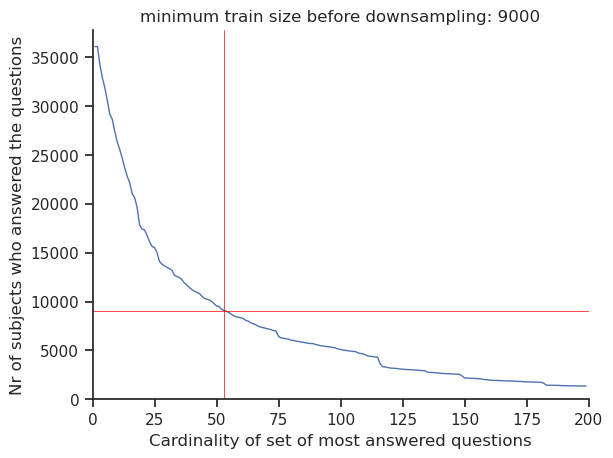

In [9]:
for n, min_size in zip(n_most_answered[:2], min_train_size):
    sns.set_style("white")
    sns.set_style("ticks")
    g = sns.lineplot(x = range(1,K), y = subset_size_topk, linewidth=1)
    g.axhline(y=min_size, color='red', linewidth=0.5)
    g.axvline(x=n, color='red', linewidth=0.5)

    plt.xlim(0, 200)
    plt.ylim(0)
    sns.despine()
    #plt.ylim(0,len(features_df))
    g.set(xlabel ="Cardinality of set of most answered questions", ylabel = "Nr of subjects who answered the questions")
    #title ='Nr of subjects who answered the same k most anwered questions '
    #plt.figtext(0.5, -0.1, 'Grouping most answered questions into a set, comparing the number of questions in the set to the number of subjects who answered all questions in the set', wrap=True, horizontalalignment='center', fontsize=12)
    plt.title(f'minimum train size before downsampling: {min_size}')
    plt.show()

## HPO: Optimize Ratio: (Nr of feature)/(Train set size)

In [10]:
val_scores = []

for n in n_most_answered:
    top_questions = sorted_questions[:n].to_list()
    filter_by = top_questions + ['political_belief']
    downsampled_df = df_trn[filter_by].dropna()
    n_conservative = downsampled_df.groupby('political_belief').count().iloc[1, 0]
    downsampled_df = downsampled_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))


    # split into features and target
    features_df_downsampled = downsampled_df[top_questions]
    target = downsampled_df.loc[features_df_downsampled.index][['political_belief']]

    # encode train and validation set
    feature_encoder = OrdinalEncoder()
    target_encoder = LabelEncoder()
    # train set
    X_train_encoded = feature_encoder.fit_transform(features_df_downsampled)
    y_train_encoded = target_encoder.fit_transform(target.values.ravel())
    # val set
    X_val_encoded = feature_encoder.transform(X_val_topq[top_questions])
    y_val_encoded = target_encoder.transform(y_val.values.ravel())

    # Naive Bayes Hyper parameter Tuning
    nb = CategoricalNB(fit_prior=False).fit(X_train_encoded, y_train_encoded)
    preds = nb.predict(X_val_encoded)
    val_scores.append(balanced_accuracy_score(y_val_encoded, preds))

best_nr_of_questions = n_most_answered[np.argmax(val_scores)]
print(f'Best balanced accuracy on the validation set obtained with {best_nr_of_questions} number of answered questions')

Best balanced accuracy on the validation set obtained with 53 number of answered questions


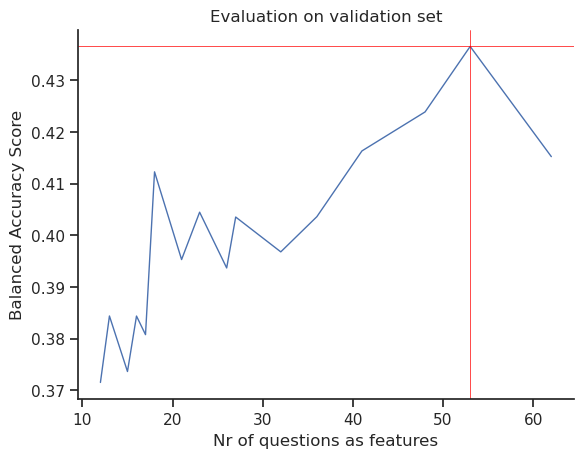

In [11]:
sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = n_most_answered, y = val_scores, linewidth=1)
g.axhline(y=np.max(val_scores), color='red', linewidth=0.5)
g.axvline(x=best_nr_of_questions, color='red', linewidth=0.5)
sns.despine()
g.set(ylabel ='Balanced Accuracy Score', xlabel ='Nr of questions as features', title='Evaluation on validation set')
plt.show()

## Downsampling the dataset with chosen features

In [12]:
top_questions = sorted_questions[:best_nr_of_questions].to_list()
filter_by = top_questions + ['political_belief', 'd_age', 'gender']
downsampled_df = data[filter_by].dropna()
n_conservative = downsampled_df.groupby('political_belief').count().iloc[1, 0]
downsampled_df = downsampled_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))
display(downsampled_df.head())

,dq823,dq789,dq821,dq109,dq8,dq305,dq373,dq420,dq10,dq141,...,dq470,dq11,dq175,dq60,dq650,dq23,dq586,political_belief,d_age,gender
index,,,,,,,,,,,,,,,,,,,,,
64195,Can't answer without a subtitle,"Red (such as Merlot, Cabernet, Shiraz).",Yes,No,Sometimes,Higher than average,Whenever possible,Usually,I never do drugs.,Yes,...,Rarely.,Sometimes,"Yes, I have a fulltime job",College,Occasionally.,No,Kill it.,Centrist,38.0,Man
26978,Yes,I don't drink wine.,Yes,No,Never,Average,Whenever possible,Usually,"I've done drugs in the past, but no longer.",Yes,...,Rarely.,Never,I'm a student,College,Never.,No,Catch it and put it outside.,Centrist,34.0,Man
34261,Yes,Rosé (such as White Zinfindel).,Yes,No,Sometimes,"Very, very high",Always,Usually,I never do drugs.,Yes,...,Rarely.,Rarely,"Yes, I have a fulltime job",Graduate School,Occasionally.,Yes,Ignore it.,Centrist,57.0,Man
64509,Yes,"Red (such as Merlot, Cabernet, Shiraz).",Yes,No,Sometimes,Higher than average,Whenever possible,Usually,I never do drugs.,Yes,...,Never.,Never,"Yes, I have a fulltime job",College,Occasionally.,Yes,Kill it.,Centrist,29.0,Woman
15312,Can't answer without a subtitle,Rosé (such as White Zinfindel).,Yes,No,Sometimes,Higher than average,Always,Usually,I never do drugs.,Yes,...,Sometimes.,Sometimes,"Yes, I have a fulltime job",College,Occasionally.,No,Catch it and put it outside.,Centrist,22.0,Woman


## Visualize of the feature distribution

In [13]:
print(top_questions)

['dq823', 'dq789', 'dq821', 'dq109', 'dq8', 'dq305', 'dq373', 'dq420', 'dq10', 'dq141', 'dq9', 'dq0', 'dq268', 'dq198', 'dq331', 'dq500', 'dq296', 'dq299', 'dq824', 'dq95', 'dq475', 'dq581', 'dq294', 'dq118', 'dq40', 'dq725', 'dq34', 'dq234', 'dq136', 'dq173', 'dq64', 'dq117', 'dq516', 'dq337', 'dq579', 'dq237', 'dq426', 'dq657', 'dq820', 'dq391', 'dq348', 'dq327', 'dq359', 'dq379', 'dq354', 'dq759', 'dq470', 'dq11', 'dq175', 'dq60', 'dq650', 'dq23', 'dq586']


In [14]:
#manually fix strange entries
questions.at['dq296', 'Order']=['Yes', 'Sometimes', 'No']
questions.at['dq299', 'Order']=['All the time', 'Sometimes', 'Rarely / never']

In [ ]:
def plot_question_distribution(question: str, data: pd.DataFrame, questions: pd.DataFrame):
    x,y = question, 'political_belief'
    title = questions.loc[question, 'text']
    df1 = data.groupby(x)[y].value_counts(normalize=True).rename('density').reset_index()

    g = sns.catplot(x=x,y='density',hue=y, kind='bar', data=df1, 
                hue_order= ['Liberal / Left-wing', 'Centrist', 'Conservative / Right-wing', 'Other'], 
                palette={'Liberal / Left-wing': '#5770db', 'Centrist': '#db57b2', 'Conservative / Right-wing': '#ba2832', 'Other': '#fdbf6f'},
                order =  questions.loc[question, 'Order'],
                legend=False
                ).set(xlabel ="", title=title)
    plt.legend(title="", bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
for question in top_questions:
    plot_question_distribution(question, downsampled_df, questions)

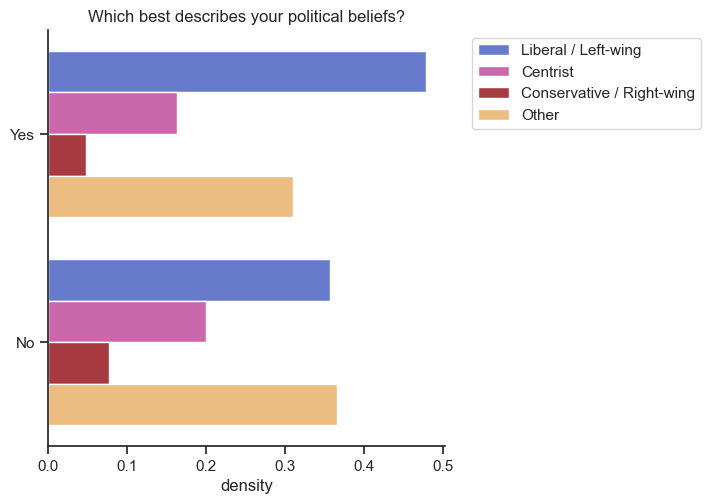

In [ ]:
def plot_question_distribution(question: str, data: pd.DataFrame, questions: pd.DataFrame):
    x,y = question, 'political_belief'
    df1 = data.groupby(x)[y].value_counts(normalize=True).rename('density').reset_index()
    title = questions.loc[question, 'text']

    g = sns.catplot(x='density',y=x,hue=y, kind='bar', data=df1, 
                hue_order= ['Liberal / Left-wing', 'Centrist', 'Conservative / Right-wing', 'Other'], 
                palette={'Liberal / Left-wing': '#5770db', 'Centrist': '#db57b2', 'Conservative / Right-wing': '#ba2832', 'Other': '#fdbf6f'},
                order = questions.loc[question, 'Order'],
                legend=False
                ).set(xlabel ="density", ylabel = "", title=title)
    plt.legend(title="", bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

for question in top_questions:
    plot_question_distribution(question, downsampled_df, questions)

## Feature Encoding: Label encoding

In [16]:
# split into features and target
features_df_topq = downsampled_df[top_questions]
target = downsampled_df.loc[features_df_topq.index][['political_belief']]

In [17]:
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(features_df_topq)
y_train_encoded = target_encoder.fit_transform(target.values.ravel())

In [18]:
print('Size of final downsampled trainset')
X_train_encoded.shape

Size of final downsampled trainset


(2964, 53)

# Baseline Model: Naive Bayes

In [19]:
nb = CategoricalNB(fit_prior=False).fit(X_train_encoded, y_train_encoded)
scores = cross_val_score(nb, X_train_encoded, y_train_encoded, cv=3, scoring='balanced_accuracy')
print(f"balanced accuracy with mean: {scores.mean()} a standard deviation of {scores.std()}")

balanced accuracy with mean: 0.4281376518218623 a standard deviation of 0.020039463434436574


In [20]:
# Save model
dump(nb, 'models/nb_downsampled_trn_set.joblib') 

['models/nb_downsampled_trn_set.joblib']

# Random Forest Classifier
## Hyperparameter Tuning
HPT using Random Search with downsampled K-fold crossvalidation \
Chosen scoring metrics: balanced accuracy (average of recall obtained on each class)

In [21]:
# Choose parameter distributions
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 8)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10,12,15 ]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
              'bootstrap': bootstrap,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10, 12, 15],
 'n_estimators': [200, 385, 571, 757, 942, 1128, 1314, 1500]}


In [22]:
rf = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_random = RandomizedSearchCV(estimator = rf,
                             param_distributions = param_grid, 
                             n_iter = 300, 
                             cv = 3, 
                             verbose=2, 
                             random_state=42, 
                             n_jobs = -1, 
                             scoring='balanced_accuracy')
rf_random.fit(X_train_encoded, y_train_encoded)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=1),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 12, 15],
                                        'n_estimators': [200, 385, 571, 757,
                                                         942, 1128, 1314,
                                                         1500]},
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [23]:
print('Results of parameter tuning with random search:')
best_random_params = rf_random.best_params_
pprint(best_random_params)

Results of parameter tuning with random search:
{'bootstrap': True,
 'max_depth': 70,
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 1500}


In [24]:
rf_tuned = rf_random.best_estimator_
scores = cross_val_score(rf_tuned, X_train_encoded, y_train_encoded, cv=5, scoring='balanced_accuracy')
print(f"balanced accuracy with mean: {scores.mean()} a standard deviation of {scores.std()}")

balanced accuracy with mean: 0.43054824959187377 a standard deviation of 0.02909952843946458


In [25]:
# save model
dump(rf_tuned, 'models/rf_downsampled_trn_set.joblib') 

['models/rf_downsampled_trn_set.joblib']

## Visualize feature importance

In [26]:
fi_df = get_sorted_feat_importance(rf_tuned.feature_importances_, features_df_topq.columns)
print('Top 20 Features sorted by their gini impotance scores ')
for i, row in fi_df[:20].iterrows():
    print(f"Feature {row['feature_names']}: {questions.loc[row['feature_names']].text}: {row['feature_importance']}")

Top 20 Features sorted by their gini impotance scores 
Feature dq824: How do you feel about documentaries?: 0.040540347354491704
Feature dq586: If you discovered a spider on the wall in your bedroom, which would you do?: 0.03782555902047391
Feature dq9: What's your relationship with marijuana?: 0.03753320000125685
Feature dq379: 'Your a bitch!' What bothers you more about the above sentence?: 0.03621839495826509
Feature dq823: Do you like watching foreign movies with subtitles?: 0.03484037741333888
Feature dq426: Are you ready to settle down and get married right now?: 0.03128743945743927
Feature dq348: You're dating someone new. You discover that they have a housemate the same sex as you. This:: 0.029356032252072943
Feature dq268: If you had to name your greatest motivation in life thus far, what would it be?: 0.028830957629351717
Feature dq60: What's the highest level of education you've completed?: 0.027413010364362087
Feature dq789: Which type of wine would you prefer to drink outs

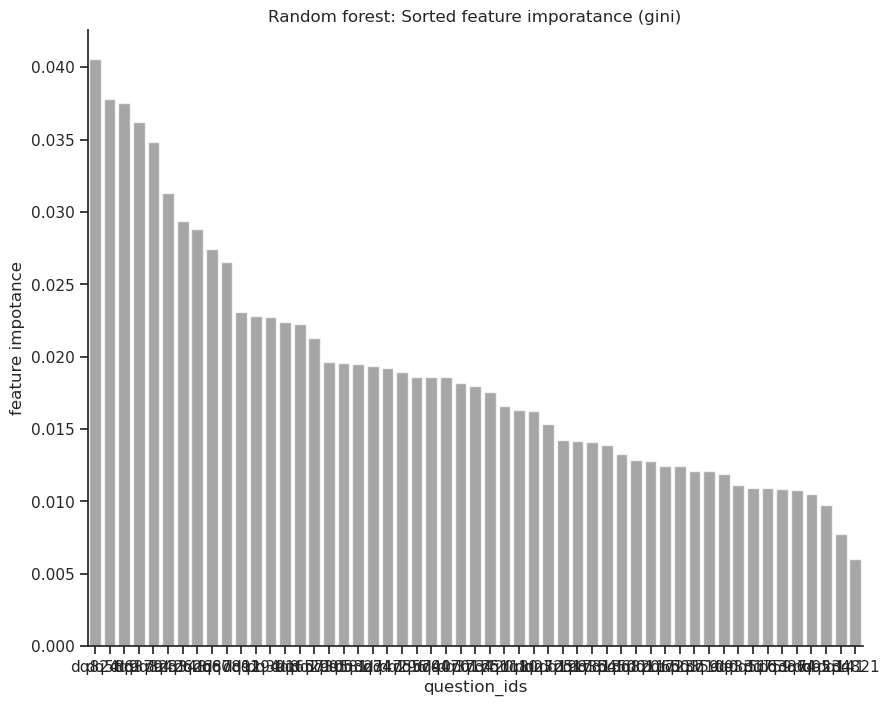

In [27]:
#Define size of bar plot
plt.figure(figsize=(10,8))
sns.set_style("white")
sns.set_style("ticks")
#Plot Searborn bar chart
g = sns.barplot(y=fi_df['feature_importance'].values, x=np.arange(len(fi_df.index)), color='gray', alpha=0.7)
sns.despine()

g.set_xticklabels(fi_df['feature_names'])
#Add chart labels
g.set_title('Random forest: Sorted feature imporatance (gini)')
g.set(ylabel ='feature impotance', xlabel ='question_ids')
plt.show()

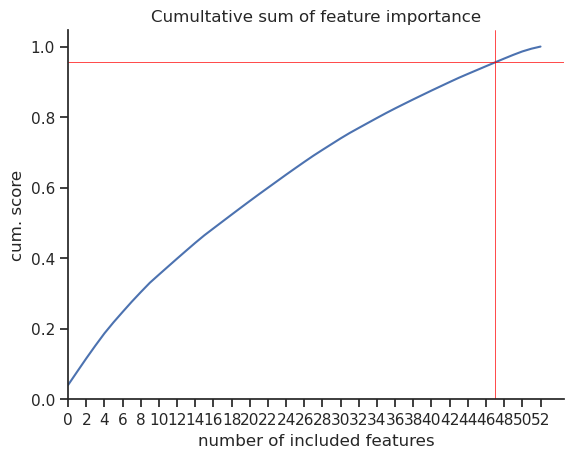

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=571; total time=   3.6s
[CV] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=12, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=1314; total time=   7.7s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=12, n_estimators=1128; total time=   7.3s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=4, min_samples_split=12, n_estimators=1314; total time=   8.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=1314; total time=  11.1s
[CV] END bootstrap=True, max_depth=110, min_samples

In [28]:
# first top k question, s.t. Cumultative sum of feature importance is >=.95
cum_sum_top_k = next(x[0] for x in enumerate(fi_df.cum_sum_fi) if x[1] >=0.95)

sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = np.arange(len(fi_df)), y = fi_df['cum_sum_fi'])
g.axhline(y=fi_df['cum_sum_fi'].iloc[cum_sum_top_k], color='red', linewidth=0.5)
g.axvline(x=cum_sum_top_k, color='red', linewidth=0.5)
sns.despine()
plt.ylim(0)
plt.xlim(0)
g.set(xlabel='number of included features', ylabel='cum. score', title='Cumultative sum of feature importance', xticks=np.arange(len(fi_df), step=2))
plt.show()

# Evaluation

## Permutatin Test

## Cross Validation 